### "Шапка" с названием проекта

В этой ячейке вы найдете оглавление и ключевые этапы работы, которые помогут вам ориентироваться в процессе выполнения проекта. Проект разделен на пять основных этапов, четыре из которых (этапы 2, 3, 4 и 5) вам предлагается выполнить в этом Jupyter Notebook:

- Подготовка среды MLflow - Первый шаг, подготовка и запуск сервисов MLflow, был выполнен вне ноутбука и оформлен в виде shell скрипта. Это основа для работы с экспериментами и логирования результатов ваших моделей.

- Этап 2 - Исследовательский Анализ Данных (EDA): На этом этапе вы проведете тщательный анализ данных, чтобы лучше понять их структуру и особенности.

- Этап 3 - Генерация Признаков и Обучение Модели: После анализа данных вы сгенерируете новые признаки и обучите модель, используя эти признаки.

- Этап 4 - Отбор Признаков и Обучение Модели: На этом шаге вы отберете наиболее значимые признаки и снова обучите модель для улучшения ее качества.

- Этап 5 - Подбор Гиперпараметров и Обучение Финальной Версии Модели: Финальный этап проекта посвящен оптимизации гиперпараметров для достижения максимального качества модели.

Для удобства навигации и организации работы, пожалуйста, следуйте оглавлению и рекомендациям, описанным в каждом этапе.

> ### Важно: Переобучение моделей
> На каждом этапе проекта, где требуется переобучение модели, важно не просто выполнить эту процедуру, но и тщательно проверить качество модели на соответствующих выборках. Это включает в себя анализ метрик качества, визуализацию результатов, сравнение с предыдущими моделями и, при необходимости, корректировку.

> ### Важно: Разделение выборок
> Перед началом выполнения вашего проекта важно правильно подготовить данные, разделив их на подвыборки. Это позволит оценить производительность модели более объективно и управлять риском переобучения. В зависимости от ваших целей и доступных данных, вы можете использовать различные стратегии разделения:

1. Разделение на train/val/test: Это классический подход, где данные делятся на три части. Обучающая выборка (train) используется для первичного обучения моделей, валидационная (val) - для настройки гиперпараметров и выбора лучшей модели, а тестовая (test) - для финальной оценки производительности модели. Такой подход идеален, если у вас достаточно данных, чтобы разделить их и каждая из выборок была репрезентативна.

2. Разделение на train/test с кросс-валидацией на train: Если данных недостаточно для трех подвыборок, можно ограничиться разделением на обучающую и тестовую выборки. В этом случае кросс-валидация на обучающей выборке поможет оценить стабильность модели и подобрать гиперпараметры.

Определение способа разделения данных: Выбор метода разбиения данных на подвыборки — train, validation и test — должен быть обоснован особенностями вашего набора данных и задачами проекта. Возможные методы разделения, включая различные стратегии и правила, подробно описаны в [документации scikit-learn по разбиению данных](https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py). Вы можете следовать этим примерам или разработать собственный метод, исходя из специфики ваших данных.

Ваша задача - выбрать подходящий метод разделения данных исходя из объема и специфики ваших данных. Помните, что финальные метрики качества модели мы будем оценивать на тестовой выборке. Промежуточные результаты после каждого этапа проекта (например, после настройки гиперпараметров) следует оценивать на валидационной выборке, если таковая имеется. Это поможет вам корректно настроить модель перед финальной оценкой её производительности.

Загружаем данные

In [50]:
import psycopg
import pandas as pd
from dotenv import load_dotenv

load_dotenv()

TABLE_NAME = "clean_flats_full_info"

connection = {"sslmode": "require", "target_session_attrs": "read-write"}
postgres_credentials = {
    "host": "rc1b-uh7kdmcx67eomesf.mdb.yandexcloud.net", 
    "port": "6432",
    "dbname": "playground_mle_20240328_6bcf522120",
    "user": "mle_20240328_6bcf522120",
    "password": "0c5b03147fbf49b585770e53719feac4",
}
assert all([var_value != "" for var_value in list(postgres_credentials.values())])

connection.update(postgres_credentials)

with psycopg.connect(**connection) as conn:
    with conn.cursor() as cur:
        cur.execute(f"SELECT * FROM {TABLE_NAME}")
        data = cur.fetchall()
        columns = [col[0] for col in cur.description]

initial_df = pd.DataFrame(data, columns=columns)
initial_df.head(2) 
initial_df.shape

(111438, 20)

Настройка MLFLOW

In [51]:
import os
import mlflow
from dotenv import load_dotenv

load_dotenv()

TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net"
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID")
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY")

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

In [3]:
initial_df.head(2)

id  build_year  building_type_int   latitude  longitude  ceiling_height   
0   1        1965                  6  55.717113  37.781120            2.64  \
1   2        2001                  2  55.794849  37.608013            3.00   

   flats_count  floors_total  has_elevator  flat_id  building_id  floor   
0           84            12          True        0         6220      9  \
1           97            10          True        1        18012      7   

   is_apartment  kitchen_area  living_area  rooms  studio  total_area   
0         False           9.9         19.9      1   False   35.099998  \
1         False           0.0         16.6      1   False   43.000000   

      price      target  
0   9500000   9500000.0  
1  13500000  13500000.0

In [52]:
# сделайте разделение изначального набора данных в этой ячейке

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split

target = initial_df['target']
df = initial_df.drop(['id', 'price', 'building_id', 'target'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(df, target, random_state=0)

#### Этап 2: Исследовательский Анализ Данных (EDA)
На этом этапе ваша задача - провести тщательный исследовательский анализ данных (EDA), чтобы глубже понять особенности и связи в предоставленном наборе данных. В процессе EDA вы должны обратить внимание на три ключевых аспекта, о которых мы говорили в теме 3 курса. Очень важно, чтобы все результаты вашего исследования, включая визуализации, статистический анализ и предварительные выводы, были аккуратно залогированы в MLflow.

Для более организованного исследования предлагаем следующие рекомендуемые шаги:
- Понимание данных: Первоначально ознакомьтесь с данными, изучите типы данных, проверьте наличие пропущенных значений.
- Визуализация данных: Используйте графики и диаграммы для визуализации распределений признаков и возможных взаимосвязей между ними.
- Статистический анализ: Примените статистические методы для изучения центральных тенденций, разброса и корреляций между признаками.
- Предварительные выводы: На основе проведённого анализа сформулируйте предварительные выводы о данных, которые помогут в дальнейшем этапе моделирования.

Помните, что EDA - это итеративный процесс, в котором вы можете возвращаться к предыдущим шагам для дополнительного анализа, если это будет необходимо. Все находки и выводы должны быть чётко зафиксированы и легко доступны для команды проекта.


In [ ]:
# 2.1 Загрузка данных

# Уже сделано выше

In [ ]:
# 2.2. Общий обзор датасета

In [5]:
import pandas as pd

pd.options.display.max_columns = 100
pd.options.display.max_rows = 64 

In [4]:
import pandas as pd
from sklearn.datasets import make_classification

print("первые 5 строк")
X_train.head(5)

первые 5 строк


build_year  building_type_int   latitude  longitude  ceiling_height   
46400        2011                  2  55.512039  37.573662            2.80  \
80614        2007                  4  55.534546  37.503010            2.64   
90376        1966                  0  55.846119  37.578827            2.64   
84716        1993                  4  55.666466  37.451286            2.64   
94633        2013                  2  55.604752  37.664024            2.70   

       flats_count  floors_total  has_elevator  flat_id  floor  is_apartment   
46400          332            15          True    57875     11         False  \
80614          172            22          True   101954     14         False   
90376           72             9          True   114960      5         False   
84716          252            22          True   107082     22         False   
94633          289            11          True   120640      5         False   

       kitchen_area  living_area  rooms  studio  total_area  
46400          13.0     0.000000      2   False   48.400002  
80614          10.0    52.700001      3   False   87.599998  
90376           5.0    21.000000      1   False   31.000000  
84716          10.0    20.000000      1   False   38.500000  
94633          12.1    34.900002      2   False   63.099998

In [5]:
print("последние 5 строк")
X_train.tail(5)

последние 5 строк


build_year  building_type_int   latitude  longitude  ceiling_height   
21243        1980                  4  55.859509  37.408588            2.64  \
45891        2020                  2  55.879494  37.539886            3.00   
42613        2014                  0  55.465111  37.288177            3.30   
43567        1974                  4  55.585911  37.664867            2.64   
68268        1972                  6  55.802704  37.722046            2.48   

       flats_count  floors_total  has_elevator  flat_id  floor  is_apartment   
21243          127            16          True    25938      1         False  \
45891         1057            22         False    57262      9         False   
42613           50             6          True    52824      5         False   
43567          215             9          True    54127      8         False   
68268          214            12          True    86278      1         False   

       kitchen_area  living_area  rooms  studio  total_area  
21243      8.300000    30.600000      2   False   52.099998  
45891      0.000000    30.000000      2   False   36.000000  
42613     22.700001    15.100000      2   False   57.000000  
43567      6.500000    22.100000      1   False   36.700001  
68268      7.900000    19.700001      1   False   35.900002

In [6]:
# посмотрим типы данных в столбцах датафрейма

X_train.dtypes

build_year             int64
building_type_int      int64
latitude             float64
longitude            float64
ceiling_height       float64
flats_count            int64
floors_total           int64
has_elevator            bool
flat_id                int64
floor                  int64
is_apartment            bool
kitchen_area         float64
living_area          float64
rooms                  int64
studio                  bool
total_area           float64
dtype: object

In [7]:
# основные статистические характеристики числовых данных

num_cols = X_train.select_dtypes(include=[float, int])

num_cols.describe()

build_year  building_type_int      latitude     longitude   
count  83578.00000       83578.000000  83578.000000  83578.000000  \
mean    1985.56674           3.403013     55.729446     37.592849   
std       20.68957           1.432540      0.107471      0.156390   
min     1901.00000           0.000000     55.211460     36.864372   
25%     1969.00000           2.000000     55.647205     37.491154   
50%     1982.00000           4.000000     55.718761     37.586735   
75%     2005.00000           4.000000     55.814851     37.711899   
max     2023.00000           6.000000     56.011032     37.946411   

       ceiling_height   flats_count  floors_total        flat_id   
count    83578.000000  83578.000000  83578.000000   83578.000000  \
mean         2.713916    252.710043     13.688040   70063.737228   
std          0.193440    198.550388      6.286094   41166.724002   
min          2.000000      1.000000      1.000000       0.000000   
25%          2.640000    116.000000      9.000000   34133.250000   
50%          2.640000    204.000000     14.000000   70113.500000   
75%          2.740000    325.000000     17.000000  105653.500000   
max         27.000000   4455.000000     99.000000  141359.000000   

              floor  kitchen_area   living_area         rooms    total_area  
count  83578.000000  83578.000000  83578.000000  83578.000000  83578.000000  
mean       7.221601      8.500377     28.048151      1.965182     53.161152  
std        5.332951      3.831055     15.512242      0.828994     18.071326  
min        1.000000      0.000000      0.000000      1.000000     11.000000  
25%        3.000000      6.100000     19.000000      1.000000     38.799999  
50%        6.000000      8.500000     28.799999      2.000000     50.299999  
75%       10.000000     10.000000     37.000000      3.000000     63.000000  
max       56.000000    102.000000    152.300000      7.000000    309.000000

In [8]:
# убедимся, что нет пропущенных значений

X_train.isnull().sum().sort_values(ascending=False)

build_year           0
building_type_int    0
latitude             0
longitude            0
ceiling_height       0
flats_count          0
floors_total         0
has_elevator         0
flat_id              0
floor                0
is_apartment         0
kitchen_area         0
living_area          0
rooms                0
studio               0
total_area           0
dtype: int64

In [9]:
# и бесконечных

import numpy as np

X_train.isin([-np.inf, np.inf]).sum().sort_values(ascending=False)

build_year           0
building_type_int    0
latitude             0
longitude            0
ceiling_height       0
flats_count          0
floors_total         0
has_elevator         0
flat_id              0
floor                0
is_apartment         0
kitchen_area         0
living_area          0
rooms                0
studio               0
total_area           0
dtype: int64

In [10]:
# Число уникальных значений

X_train.nunique()

build_year             118
building_type_int        7
latitude             14620
longitude            14222
ceiling_height          65
flats_count            706
floors_total            60
has_elevator             2
flat_id              83578
floor                   54
is_apartment             2
kitchen_area           746
living_area           1508
rooms                    7
studio                   1
total_area            1946
dtype: int64

In [ ]:
# 2.3 Анализ признаков для модели

In [53]:
import os

EDA_ASSETS_DIR = "eda_assets"

if not os.path.isdir(EDA_ASSETS_DIR):
    os.mkdir(EDA_ASSETS_DIR)

2024-08-22 13:20:22,321 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-08-22 13:20:22,344 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-08-22 13:20:22,507 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-08-22 13:20:22,518 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


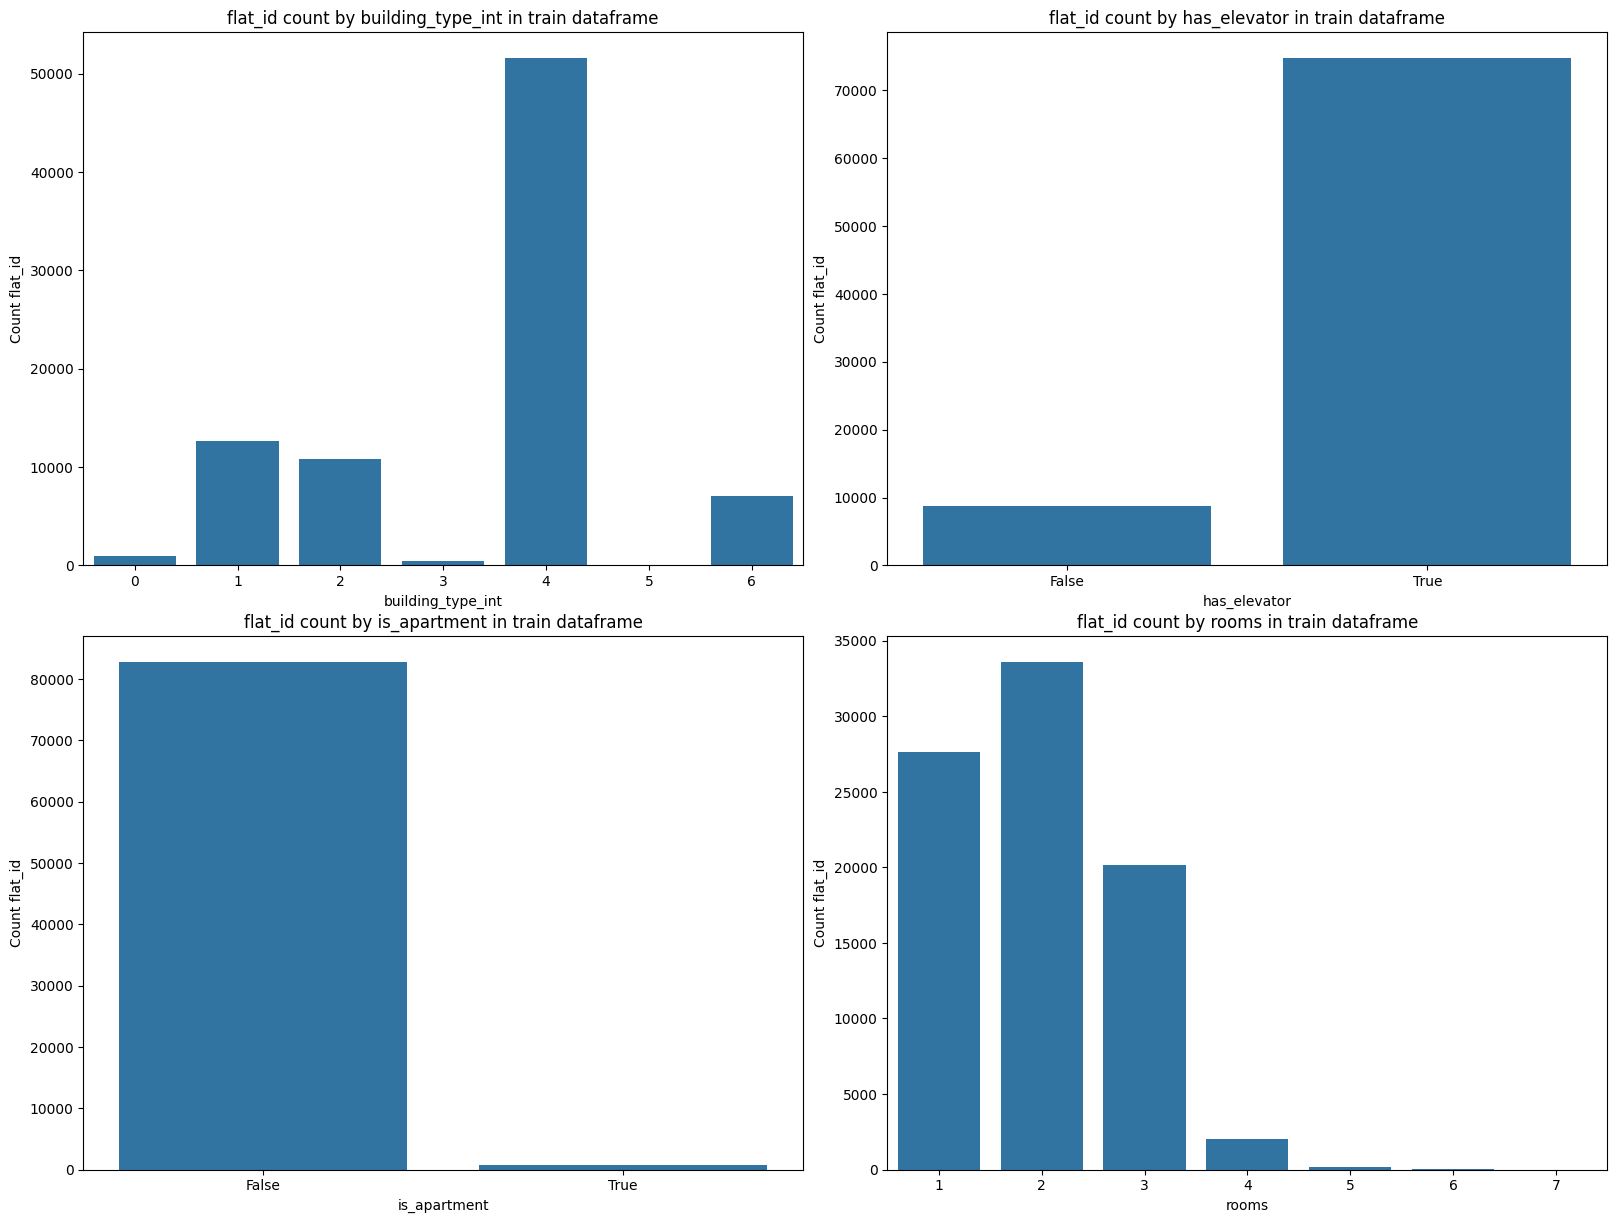

In [74]:
# Количество уникальных значений flat id, сгрупированное по building_type_int, has_elevator, is_apartment, rooms

import matplotlib.pyplot as plt
import seaborn as sns
import os

fig, axs = plt.subplots(2, 2)
fig.set_size_inches(16.5, 12.5, forward=True)
fig.tight_layout(pad=3.0)

x = ["building_type_int", "has_elevator", "is_apartment", "rooms"]
y = "flat_id"

agg_df = pd.DataFrame(X_train.groupby(x[0]).agg({y: 'count'})).reset_index() 
agg_df.columns = [x[0], f'Count {y}']
sns.barplot(data=agg_df, x=x[0], y=f'Count {y}', ax=axs[0, 0])
axs[0, 0].set_title(f'{y} count by {x[0]} in train dataframe')

agg_df = pd.DataFrame(X_train.groupby(x[1]).agg({y: 'count'})).reset_index() 
agg_df.columns = [x[1], f'Count {y}']
sns.barplot(data=agg_df, x=x[1], y=f'Count {y}', ax=axs[0, 1])
axs[0, 1].set_title(f'{y} count by {x[1]} in train dataframe')

agg_df = pd.DataFrame(X_train.groupby(x[2]).agg({y: 'count'})).reset_index() 
agg_df.columns = [x[2], f'Count {y}']
sns.barplot(data=agg_df, x=x[2], y=f'Count {y}', ax=axs[1, 0])
axs[1, 0].set_title(f'{y} count by {x[2]} in train dataframe')

agg_df = pd.DataFrame(X_train.groupby(x[3]).agg({y: 'count'})).reset_index()
agg_df.columns = [x[3], f'Count {y}'] 
sns.barplot(data=agg_df, x=x[3], y=f'Count {y}', ax=axs[1, 1])
axs[1, 1].set_title(f'{y} count by {x[3]} in train dataframe')

plt.savefig(os.path.join(EDA_ASSETS_DIR, 'cat_features_1'))

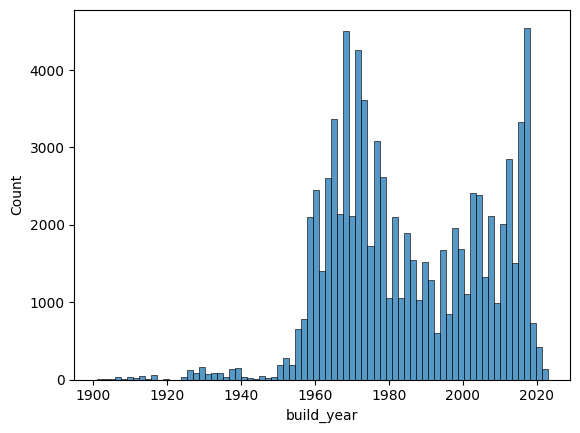

In [75]:
# Число квартир по годам

import matplotlib.pyplot as plt
import seaborn as sns
sns.histplot(X_train['build_year'])
plt.savefig(os.path.join(EDA_ASSETS_DIR, 'build_year_1'))

In [ ]:
# 2.4 Анализ целевой переменной

In [20]:
y_train.describe()

count    8.357800e+04
mean     1.218883e+07
std      4.857764e+06
min      1.100000e+01
25%      8.600000e+06
50%      1.100000e+07
75%      1.450000e+07
max      2.840000e+07
Name: target, dtype: float64

In [ ]:
# 2.4 Анализ целевой переменной в зависимости от различных признаков

In [77]:
df = pd.concat([X_train, y_train], axis=1)
df

build_year  building_type_int   latitude  longitude  ceiling_height   
46400        2011                  2  55.512039  37.573662            2.80  \
80614        2007                  4  55.534546  37.503010            2.64   
90376        1966                  0  55.846119  37.578827            2.64   
84716        1993                  4  55.666466  37.451286            2.64   
94633        2013                  2  55.604752  37.664024            2.70   
...           ...                ...        ...        ...             ...   
21243        1980                  4  55.859509  37.408588            2.64   
45891        2020                  2  55.879494  37.539886            3.00   
42613        2014                  0  55.465111  37.288177            3.30   
43567        1974                  4  55.585911  37.664867            2.64   
68268        1972                  6  55.802704  37.722046            2.48   

       flats_count  floors_total  has_elevator  flat_id  floor  is_apartment   
46400          332            15          True    57875     11         False  \
80614          172            22          True   101954     14         False   
90376           72             9          True   114960      5         False   
84716          252            22          True   107082     22         False   
94633          289            11          True   120640      5         False   
...            ...           ...           ...      ...    ...           ...   
21243          127            16          True    25938      1         False   
45891         1057            22         False    57262      9         False   
42613           50             6          True    52824      5         False   
43567          215             9          True    54127      8         False   
68268          214            12          True    86278      1         False   

       kitchen_area  living_area  rooms  total_area      target  
46400     13.000000     0.000000      2   48.400002   8500000.0  
80614     10.000000    52.700001      3   87.599998  15900000.0  
90376      5.000000    21.000000      1   31.000000   7300000.0  
84716     10.000000    20.000000      1   38.500000   8100000.0  
94633     12.100000    34.900002      2   63.099998  11200000.0  
...             ...          ...    ...         ...         ...  
21243      8.300000    30.600000      2   52.099998   9500000.0  
45891      0.000000    30.000000      2   36.000000  10900000.0  
42613     22.700001    15.100000      2   57.000000  15150000.0  
43567      6.500000    22.100000      1   36.700001   5750000.0  
68268      7.900000    19.700001      1   35.900002   6450000.0  

[83578 rows x 16 columns]

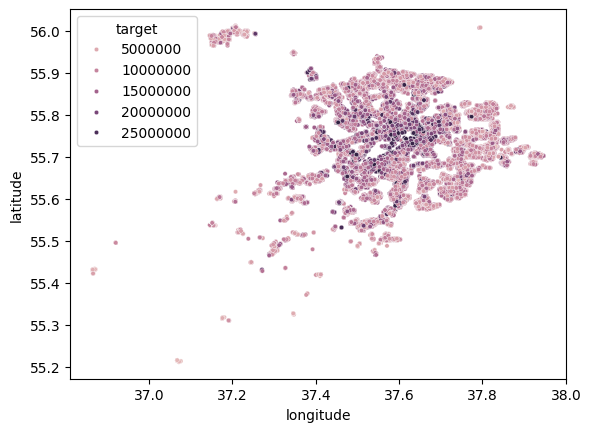

In [80]:
# Влияние локации на стоимость
sns.scatterplot(data=df, x="longitude", y="latitude", hue="target", s=10)
plt.savefig(os.path.join(EDA_ASSETS_DIR, 'location_price_1'))

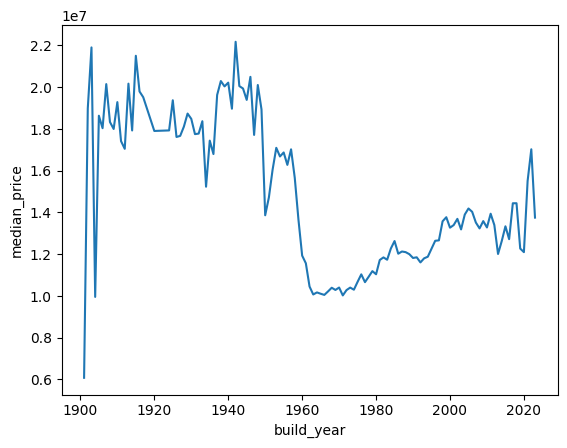

In [81]:
# Средняя стоимость по годам

import seaborn as sns
import numpy as np

agg_df = df[['build_year', 'target']].groupby("build_year").agg({"target": 'mean'}).reset_index() 
agg_df.columns = ['build_year', 'median_price']

sns.lineplot(agg_df, x="build_year", y='median_price')
plt.savefig(os.path.join(EDA_ASSETS_DIR, 'price_build_year_1'))

2024-08-22 13:22:05,901 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-08-22 13:22:05,927 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


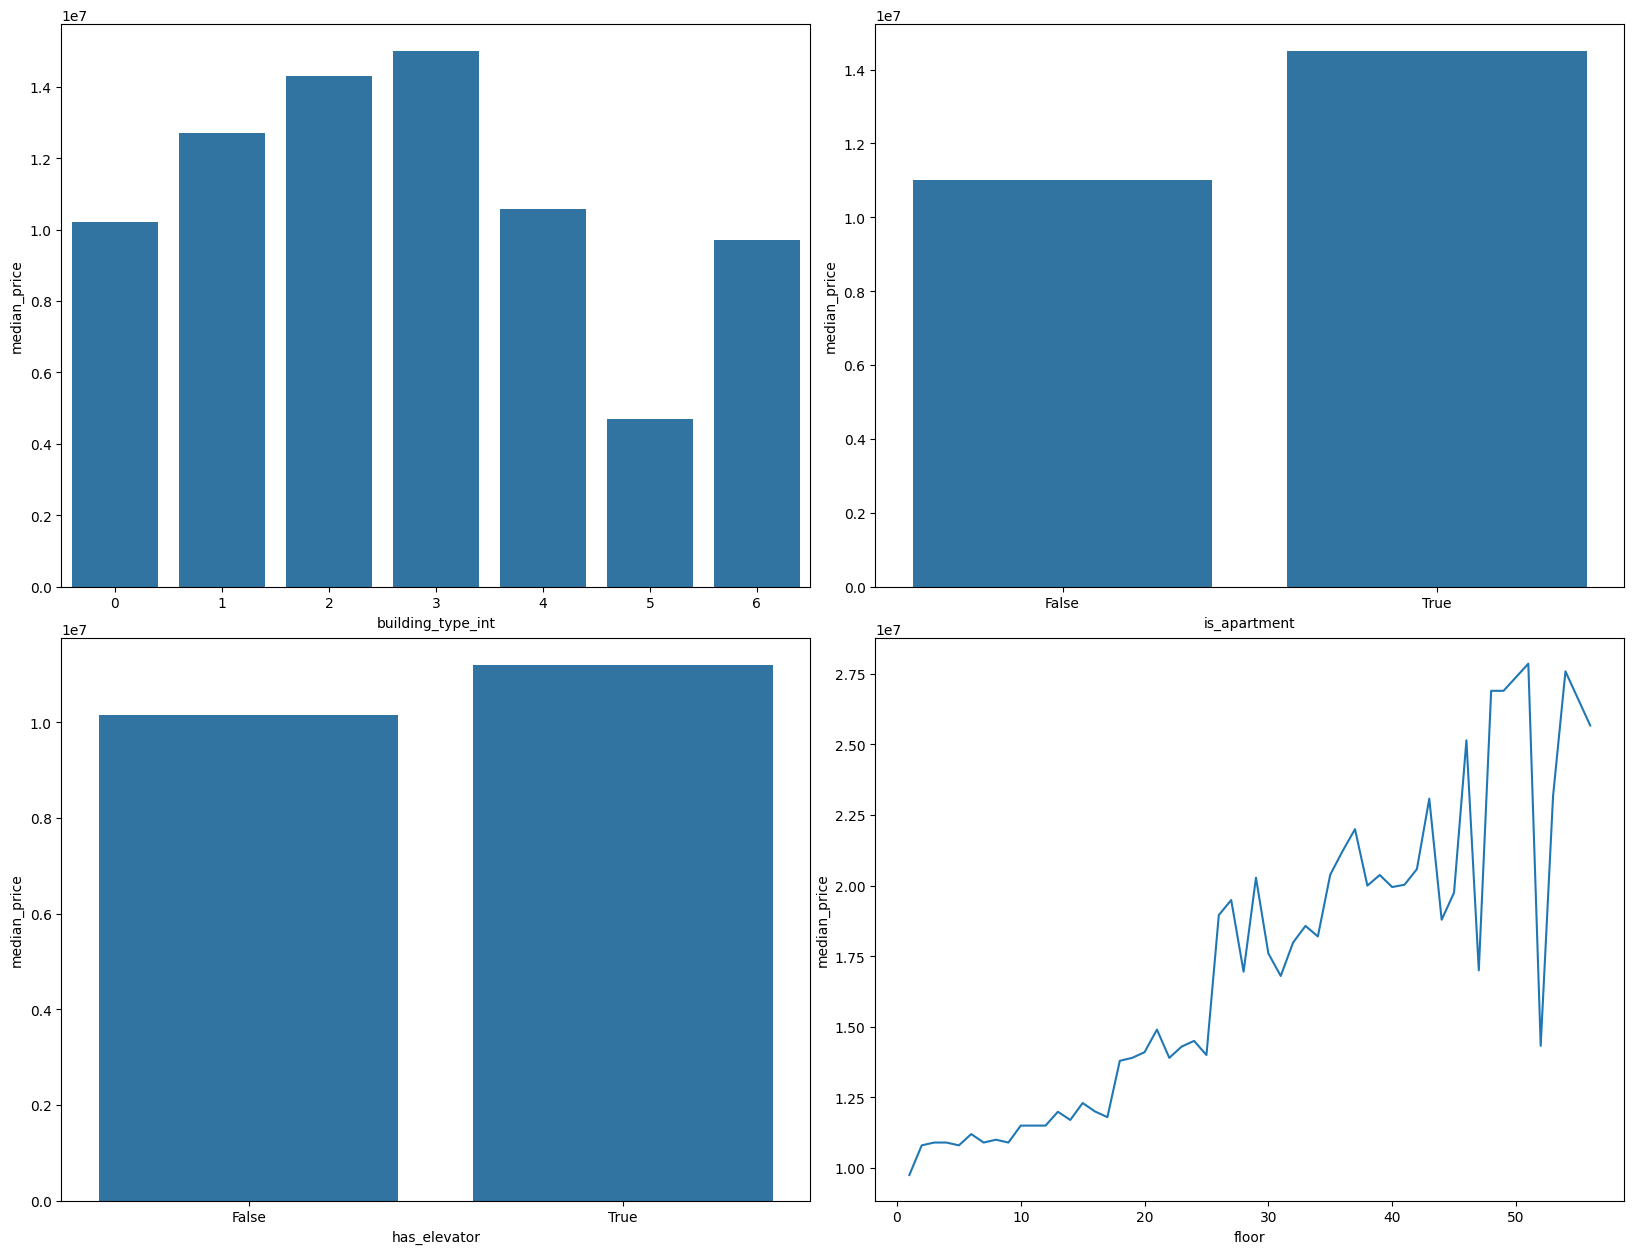

In [82]:
import seaborn as sns
import numpy as np


fig, axs = plt.subplots(2, 2)
fig.set_size_inches(16.5, 12.5, forward=True)
fig.tight_layout(pad=1.6)

agg_df1 = df[['building_type_int', 'target']].groupby("building_type_int").agg({"target": 'median'}).reset_index() 
agg_df1.columns = ['building_type_int', 'median_price']

agg_df2 = df[['is_apartment', 'target']].groupby("is_apartment").agg({"target": 'median'}).reset_index() 
agg_df2.columns = ['is_apartment', 'median_price']

agg_df3 = df[['has_elevator', 'target']].groupby("has_elevator").agg({"target": 'median'}).reset_index() 
agg_df3.columns = ['has_elevator', 'median_price']

agg_df4 = df[['floor', 'target']].groupby("floor").agg({"target": 'median'}).reset_index() 
agg_df4.columns = ['floor', 'median_price']

sns.barplot(agg_df1, ax=axs[0, 0], x="building_type_int", y='median_price')
sns.barplot(agg_df2, ax=axs[0, 1], x="is_apartment", y='median_price')
sns.barplot(agg_df3, ax=axs[1, 0], x="has_elevator", y='median_price')
sns.lineplot(agg_df4, ax=axs[1, 1], x="floor", y='median_price')

plt.savefig(os.path.join(EDA_ASSETS_DIR, 'price_categorical_1'))

2024-08-22 13:24:01,017 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-08-22 13:24:01,037 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


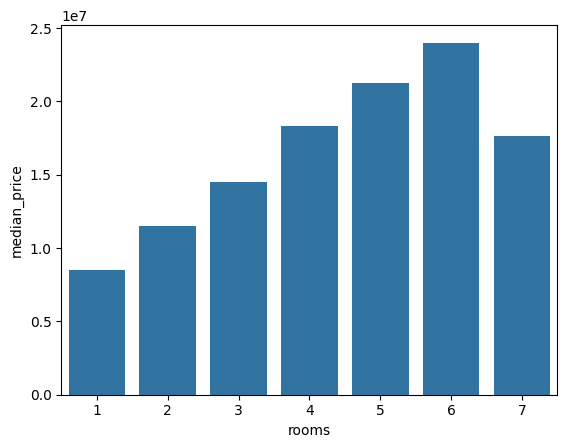

In [87]:
# Средняя стоимость по этажам

import seaborn as sns
import numpy as np



agg_df = df[['rooms', 'target']].groupby("rooms").agg({"target": 'median'}).reset_index() 
agg_df.columns = ['rooms', 'median_price']
sns.barplot(agg_df, x="rooms", y='median_price')

plt.savefig(os.path.join(EDA_ASSETS_DIR, 'price_rooms_1'))

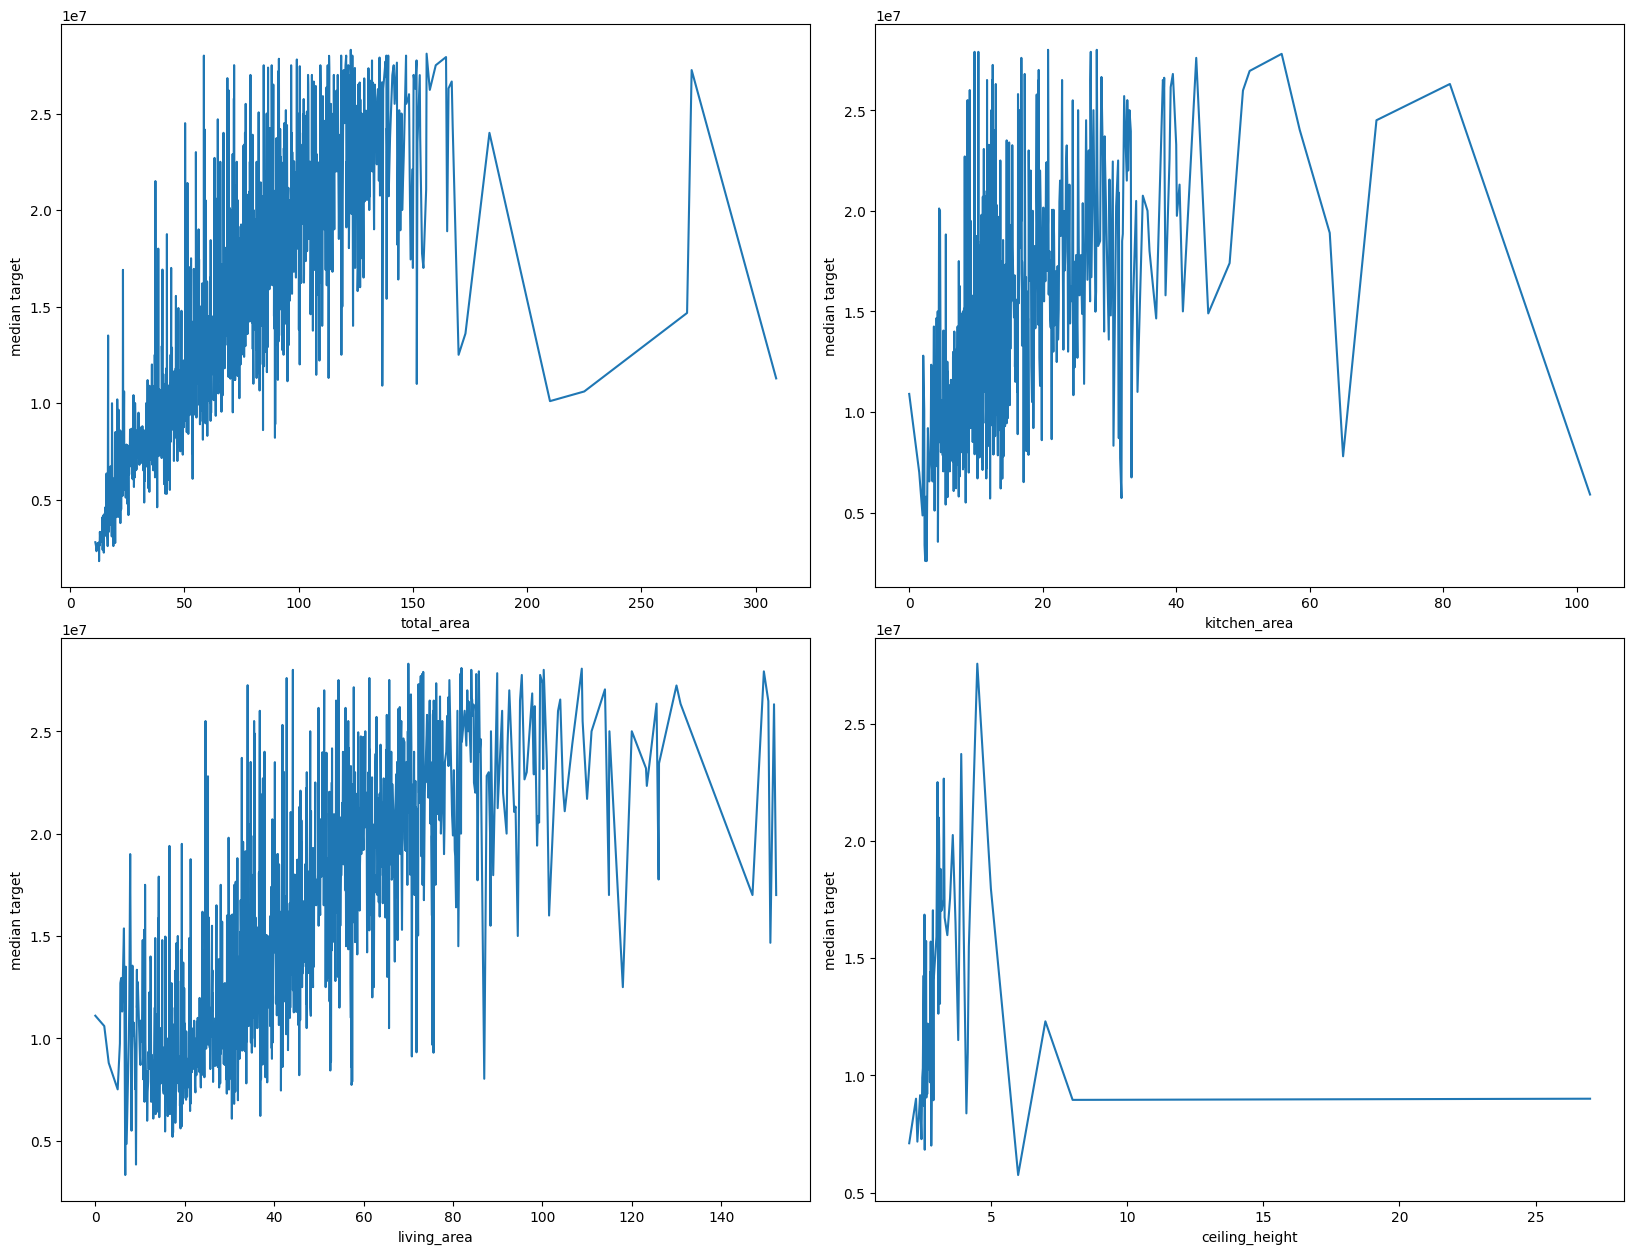

In [88]:
# Изменение цены в зависимости от площади квартиры, площади кухни, высоты потолка и площади жилой комнаты
import seaborn as sns
import numpy as np

x = ['total_area', 'kitchen_area', 'living_area', 'ceiling_height']
y = 'target'

fig, axs = plt.subplots(2, 2)
fig.set_size_inches(16.5, 12.5, forward=True)
fig.tight_layout(pad=1.6)

agg_df1 = df[[x[0], y]].groupby(x[0]).agg({y: 'median'}).reset_index() 
agg_df1.columns = [x[0], f'median {y}']
sns.lineplot(agg_df1, x=x[0], y=f'median {y}', ax=axs[0, 0])

agg_df1 = df[[x[1], y]].groupby(x[1]).agg({y: 'median'}).reset_index() 
agg_df1.columns = [x[1], f'median {y}']
sns.lineplot(agg_df1, x=x[1], y=f'median {y}', ax=axs[0, 1])

agg_df1 = df[[x[2], y]].groupby(x[2]).agg({y: 'median'}).reset_index() 
agg_df1.columns = [x[2], f'median {y}']
sns.lineplot(agg_df1, x=x[2], y=f'median {y}', ax=axs[1, 0])

agg_df1 = df[[x[3], y]].groupby(x[3]).agg({y: 'median'}).reset_index() 
agg_df1.columns = [x[3], f'median {y}']
sns.lineplot(agg_df1, x=x[3], y=f'median {y}', ax=axs[1, 1])

plt.savefig(os.path.join(EDA_ASSETS_DIR, 'price_area_1'))

In [ ]:
# 2.5 Выводы после EDA

1. Квартиры до 1960 года в среднем дороже квартир после 1960 года. При этом преобладающее количество квартир было постоено примерно после 1960 года.
2. Чем выше этаж, на котором расположена квартира, тем в среднем она будет дороже.
3. Стоимость квариры не сильно зависит от наличия лифта, но наличие лифта несного увеличивает стоимость.
4. Квариры, которые являются апартаментами, в среднем дороже квартир, не являющихся апартаментами.
5. В центре плотность квартир и стоимость на них увеличивается.
6. В среднем квартиры с большей площадью и жилой площадью дороже квартир с меньшей. Сложно отследить зависимость стоимости от площади кухни. Стоимость растет с увеличением высоты потолка до высоты со значением 5. После этого стоимость падает и остается примерно на одном уровне до высоты 25. 
7. Стоимость так же зависит от типа квартиры.

In [ ]:
# 2.6 логирование артефактов в MLflow

In [89]:
import os
import mlflow
from dotenv import load_dotenv

load_dotenv()

TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net"
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID")
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY")

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

In [73]:
EXPERIMENT_NAME = 'experiment_project_sprint_2_v2' 

In [74]:

RUN_NAME = "eda_results_0"

experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)

if not experiment:
    experiment = mlflow.create_experiment(EXPERIMENT_NAME)

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id

    mlflow.log_artifacts(EDA_ASSETS_DIR) 

#### Этап 3: Генерация Признаков и Обучение Новой Версии Модели
После тщательного исследовательского анализа данных (EDA), вы, скорее всего, сформировали несколько гипотез относительно новых признаков, которые могут улучшить качество вашей модели. На этом этапе, мы предлагаем вам приступить к генерации новых признаков и последующему обучению модели, используя два подхода:

Ручная генерация признаков: Используйте ваше понимание данных и результаты EDA для создания новых признаков.
Автоматическая генерация признаков: Воспользуйтесь библиотеками для автоматической генерации признаков, чтобы облегчить и ускорить этот процесс.
Важно: Для признаков, созданных вручную, рекомендуется использовать объекты sklearn, такие как Pipeline и ColumnTransformer. Это позволит автоматизировать процесс преобразования данных и облегчить поддержку вашего проекта.

После генерации новых признаков, наступает время обучить новую версию вашей модели, используя эти признаки. Не забудьте залогировать все результаты, включая новые признаки, параметры модели и метрики качества, в MLflow для удобства отслеживания изменений и результатов.

Рекомендуемые шаги:

- Определение и генерация новых признаков на основе ваших гипотез.
- Использование библиотек для автоматической генерации признаков, если это применимо.
- Интеграция новых признаков в вашу модель с помощью Pipeline или ColumnTransformer для ручно созданных признаков.
- Обучение новой версии модели с использованием всех доступных признаков.
- Логирование результатов в MLflow для документирования и анализа эффективности новых признаков и модели.

Этот этап проекта критически важен для повышения точности и эффективности вашей модели. Тщательная работа на этом этапе может существенно повлиять на итоговое качество моделирования.


In [ ]:
# 3.1 ручная генерация признаков

In [57]:
X_train.columns

Index(['build_year', 'building_type_int', 'latitude', 'longitude',
       'ceiling_height', 'flats_count', 'floors_total', 'has_elevator',
       'flat_id', 'floor', 'is_apartment', 'kitchen_area', 'living_area',
       'rooms', 'studio', 'total_area'],
      dtype='object')

In [58]:
X_train = X_train.drop("studio", axis=1)
X_test = X_test.drop("studio", axis=1)

In [59]:
int_cols = ['build_year', 'flats_count', 'floors_total', 'floor', 'rooms']
cat_cols = ['building_type_int']

In [60]:
X_train.isna().sum()

build_year           0
building_type_int    0
latitude             0
longitude            0
ceiling_height       0
flats_count          0
floors_total         0
has_elevator         0
flat_id              0
floor                0
is_apartment         0
kitchen_area         0
living_area          0
rooms                0
total_area           0
dtype: int64

Преобразуем тренировочные данные

In [61]:
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.preprocessing import OneHotEncoder


# делим признаки по типам
df_float = X_train.select_dtypes(include="float64")
df_bool = X_train.select_dtypes(include="bool")
df_category = pd.concat([X_train[cat_cols], df_bool], axis = 1)
df_int = X_train[int_cols].reset_index()

# масштабируем признаки
transformer = StandardScaler().fit(df_float)
transformer.mean_
transformer.scale_

scaled = transformer.transform(df_float)
df_num =  pd.DataFrame(scaled, columns=df_float.columns.values).reset_index()

# one hot encoder
encoder = OneHotEncoder(sparse_output=False)
encoded_features = encoder.fit_transform(df_category)
obj_df = pd.DataFrame(encoded_features, columns = encoder.get_feature_names_out()).reset_index()

# # обработанный датасет со scale и one hot encoder
train_cleaned_df = pd.concat([obj_df, df_num, df_int], axis=1)
train_cleaned_df.columns


Index(['index', 'building_type_int_0', 'building_type_int_1',
       'building_type_int_2', 'building_type_int_3', 'building_type_int_4',
       'building_type_int_5', 'building_type_int_6', 'has_elevator_False',
       'has_elevator_True', 'is_apartment_False', 'is_apartment_True', 'index',
       'latitude', 'longitude', 'ceiling_height', 'kitchen_area',
       'living_area', 'total_area', 'index', 'build_year', 'flats_count',
       'floors_total', 'floor', 'rooms'],
      dtype='object')

In [62]:
train_cleaned_df.isna().sum()

index                  0
building_type_int_0    0
building_type_int_1    0
building_type_int_2    0
building_type_int_3    0
building_type_int_4    0
building_type_int_5    0
building_type_int_6    0
has_elevator_False     0
has_elevator_True      0
is_apartment_False     0
is_apartment_True      0
index                  0
latitude               0
longitude              0
ceiling_height         0
kitchen_area           0
living_area            0
total_area             0
index                  0
build_year             0
flats_count            0
floors_total           0
floor                  0
rooms                  0
dtype: int64

Преобразуем тестовые данные

In [63]:
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.preprocessing import OneHotEncoder


# делим признаки по типам
df_float = X_test.select_dtypes(include="float64")
df_bool = X_test.select_dtypes(include="bool")
df_category = pd.concat([X_test[cat_cols], df_bool], axis = 1)
df_int = X_test[int_cols].reset_index()

# масштабируем признаки
transformer = StandardScaler().fit(df_float)
transformer.mean_
transformer.scale_

scaled = transformer.transform(df_float)
df_num =  pd.DataFrame(scaled, columns=df_float.columns.values).reset_index()

# one hot encoder
encoder = OneHotEncoder(sparse_output=False)
encoded_features = encoder.fit_transform(df_category)
obj_df = pd.DataFrame(encoded_features, columns = encoder.get_feature_names_out()).reset_index()

# обработанный датасет со scale и one hot encoder
test_cleaned_df = pd.concat([obj_df, df_num, df_int], axis=1)
test_cleaned_df.columns

Index(['index', 'building_type_int_0', 'building_type_int_1',
       'building_type_int_2', 'building_type_int_3', 'building_type_int_4',
       'building_type_int_5', 'building_type_int_6', 'has_elevator_False',
       'has_elevator_True', 'is_apartment_False', 'is_apartment_True', 'index',
       'latitude', 'longitude', 'ceiling_height', 'kitchen_area',
       'living_area', 'total_area', 'index', 'build_year', 'flats_count',
       'floors_total', 'floor', 'rooms'],
      dtype='object')

In [64]:
test_cleaned_df.isna().sum()

index                  0
building_type_int_0    0
building_type_int_1    0
building_type_int_2    0
building_type_int_3    0
building_type_int_4    0
building_type_int_5    0
building_type_int_6    0
has_elevator_False     0
has_elevator_True      0
is_apartment_False     0
is_apartment_True      0
index                  0
latitude               0
longitude              0
ceiling_height         0
kitchen_area           0
living_area            0
total_area             0
index                  0
build_year             0
flats_count            0
floors_total           0
floor                  0
rooms                  0
dtype: int64

In [12]:
# 3.2 оборачивание всех преобразований в объекты sklearn

In [65]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

preprocessor = ColumnTransformer(
    transformers=[
        ("KBinsDiscretizer", KBinsDiscretizer(), ['latitude', 'longitude']),
        ("PolynomialFeatures", PolynomialFeatures(), ['total_area', 'living_area']),
    ],
    verbose_feature_names_out=True
) 

pipe = Pipeline(steps=[('preprocessor', preprocessor)])

# преобразование данных
pipe.fit(train_cleaned_df, y_train)
encoded = pipe.transform(train_cleaned_df)
train_manual_df = pd.DataFrame(pipe.transform(train_cleaned_df), columns=preprocessor.get_feature_names_out())
train_manual_df.head(2)


KBinsDiscretizer__latitude_0.0  KBinsDiscretizer__latitude_1.0   
0                             1.0                             0.0  \
1                             1.0                             0.0   

   KBinsDiscretizer__latitude_2.0  KBinsDiscretizer__latitude_3.0   
0                             0.0                             0.0  \
1                             0.0                             0.0   

   KBinsDiscretizer__latitude_4.0  KBinsDiscretizer__longitude_0.0   
0                             0.0                              0.0  \
1                             0.0                              0.0   

   KBinsDiscretizer__longitude_1.0  KBinsDiscretizer__longitude_2.0   
0                              0.0                              1.0  \
1                              1.0                              0.0   

   KBinsDiscretizer__longitude_3.0  KBinsDiscretizer__longitude_4.0   
0                              0.0                              0.0  \
1                              0.0                              0.0   

   PolynomialFeatures__1  PolynomialFeatures__total_area   
0                    1.0                       -0.263466  \
1                    1.0                        1.905729   

   PolynomialFeatures__living_area  PolynomialFeatures__total_area^2   
0                        -1.808141                          0.069414  \
1                         1.589196                          3.631804   

   PolynomialFeatures__total_area living_area   
0                                    0.476383  \
1                                    3.028578   

   PolynomialFeatures__living_area^2  
0                           3.269373  
1                           2.525545

In [66]:
test_manual_df = pd.DataFrame(pipe.transform(test_cleaned_df), columns=preprocessor.get_feature_names_out())
test_manual_df.head(2)

KBinsDiscretizer__latitude_0.0  KBinsDiscretizer__latitude_1.0   
0                             0.0                             0.0  \
1                             1.0                             0.0   

   KBinsDiscretizer__latitude_2.0  KBinsDiscretizer__latitude_3.0   
0                             0.0                             1.0  \
1                             0.0                             0.0   

   KBinsDiscretizer__latitude_4.0  KBinsDiscretizer__longitude_0.0   
0                             0.0                              0.0  \
1                             0.0                              0.0   

   KBinsDiscretizer__longitude_1.0  KBinsDiscretizer__longitude_2.0   
0                              1.0                              0.0  \
1                              0.0                              0.0   

   KBinsDiscretizer__longitude_3.0  KBinsDiscretizer__longitude_4.0   
0                              0.0                              0.0  \
1                              0.0                              1.0   

   PolynomialFeatures__1  PolynomialFeatures__total_area   
0                    1.0                       -0.343767  \
1                    1.0                       -1.112824   

   PolynomialFeatures__living_area  PolynomialFeatures__total_area^2   
0                         0.180793                          0.118176  \
1                        -0.657241                          1.238378   

   PolynomialFeatures__total_area living_area   
0                                   -0.062151  \
1                                    0.731394   

   PolynomialFeatures__living_area^2  
0                           0.032686  
1                           0.431966

In [67]:
train_manual_df.columns

Index(['KBinsDiscretizer__latitude_0.0', 'KBinsDiscretizer__latitude_1.0',
       'KBinsDiscretizer__latitude_2.0', 'KBinsDiscretizer__latitude_3.0',
       'KBinsDiscretizer__latitude_4.0', 'KBinsDiscretizer__longitude_0.0',
       'KBinsDiscretizer__longitude_1.0', 'KBinsDiscretizer__longitude_2.0',
       'KBinsDiscretizer__longitude_3.0', 'KBinsDiscretizer__longitude_4.0',
       'PolynomialFeatures__1', 'PolynomialFeatures__total_area',
       'PolynomialFeatures__living_area', 'PolynomialFeatures__total_area^2',
       'PolynomialFeatures__total_area living_area',
       'PolynomialFeatures__living_area^2'],
      dtype='object')

In [ ]:
# 3.3 автоматическая генерация признаков

In [68]:
from autofeat import AutoFeatRegressor
transformations = ('sqrt', 'log', '^2')

afc = AutoFeatRegressor(transformations=transformations, feateng_steps=2, n_jobs=-1)

train_auto_df = afc.fit_transform(train_cleaned_df[['total_area', 'ceiling_height']], y_train)
train_auto_df.head(2)

total_area  ceiling_height  total_area**2  ceiling_height**2   
0   -0.263466        0.445019       0.069414           0.198042  \
1    1.905729       -0.382112       3.631804           0.146010   

   ceiling_height*total_area  ceiling_height*total_area**2  
0                  -0.117247                      0.030891  
1                  -0.728203                     -1.387757

In [69]:
test_auto_df = afc.transform(test_cleaned_df[['total_area', 'ceiling_height']])
test_auto_df.head(2)

total_area  ceiling_height  total_area**2  ceiling_height**2   
0   -0.343767       -0.427130       0.118176           0.182440  \
1   -1.112824       -0.665274       1.238378           0.442589   

   ceiling_height*total_area  ceiling_height*total_area**2  
0                   0.146833                     -0.050476  
1                   0.740333                     -0.823860

In [70]:
train_auto_df.columns

Index(['total_area', 'ceiling_height', 'total_area**2', 'ceiling_height**2',
       'ceiling_height*total_area', 'ceiling_height*total_area**2'],
      dtype='object')

In [71]:
test_auto_df.columns

Index(['total_area', 'ceiling_height', 'total_area**2', 'ceiling_height**2',
       'ceiling_height*total_area', 'ceiling_height*total_area**2'],
      dtype='object')

In [ ]:
# 3.4 обучение новой версии модели

In [20]:
# объединяем датасет после autoregression и датасет после ColumnTransformer
train_ready_df = pd.concat([train_manual_df.reset_index(drop=True), 
                            train_auto_df.reset_index(drop=True),
                            train_cleaned_df.reset_index(drop=True)], 
                            axis=1).reset_index()
train_ready_df.columns

Index(['level_0', 'KBinsDiscretizer__latitude_0.0',
       'KBinsDiscretizer__latitude_1.0', 'KBinsDiscretizer__latitude_2.0',
       'KBinsDiscretizer__latitude_3.0', 'KBinsDiscretizer__latitude_4.0',
       'KBinsDiscretizer__longitude_0.0', 'KBinsDiscretizer__longitude_1.0',
       'KBinsDiscretizer__longitude_2.0', 'KBinsDiscretizer__longitude_3.0',
       'KBinsDiscretizer__longitude_4.0', 'PolynomialFeatures__1',
       'PolynomialFeatures__total_area', 'PolynomialFeatures__living_area',
       'PolynomialFeatures__total_area^2',
       'PolynomialFeatures__total_area living_area',
       'PolynomialFeatures__living_area^2', 'total_area', 'ceiling_height',
       'total_area**2', 'ceiling_height**2', 'ceiling_height*total_area',
       'ceiling_height*total_area**2', 'index', 'building_type_int_0',
       'building_type_int_1', 'building_type_int_2', 'building_type_int_3',
       'building_type_int_4', 'building_type_int_5', 'building_type_int_6',
       'has_elevator_False', 'ha

In [21]:
# объединяем датасет после autoregression и датасет после ColumnTransformer
test_ready_df = pd.concat([test_manual_df.reset_index(drop=True), 
                            test_auto_df.reset_index(drop=True),
                            test_cleaned_df.reset_index(drop=True)], 
                            axis=1).reset_index()
test_ready_df.columns

Index(['level_0', 'KBinsDiscretizer__latitude_0.0',
       'KBinsDiscretizer__latitude_1.0', 'KBinsDiscretizer__latitude_2.0',
       'KBinsDiscretizer__latitude_3.0', 'KBinsDiscretizer__latitude_4.0',
       'KBinsDiscretizer__longitude_0.0', 'KBinsDiscretizer__longitude_1.0',
       'KBinsDiscretizer__longitude_2.0', 'KBinsDiscretizer__longitude_3.0',
       'KBinsDiscretizer__longitude_4.0', 'PolynomialFeatures__1',
       'PolynomialFeatures__total_area', 'PolynomialFeatures__living_area',
       'PolynomialFeatures__total_area^2',
       'PolynomialFeatures__total_area living_area',
       'PolynomialFeatures__living_area^2', 'total_area', 'ceiling_height',
       'total_area**2', 'ceiling_height**2', 'ceiling_height*total_area',
       'ceiling_height*total_area**2', 'index', 'building_type_int_0',
       'building_type_int_1', 'building_type_int_2', 'building_type_int_3',
       'building_type_int_4', 'building_type_int_5', 'building_type_int_6',
       'has_elevator_False', 'ha

In [22]:
# удаляем повторяющиеся колонки после объединения из нового собранного датасета
train_ready_df = train_ready_df.T.drop_duplicates(keep='first').T
train_ready_df = train_ready_df.drop(['index'], axis=1)
train_ready_df.head(2)


level_0  KBinsDiscretizer__latitude_0.0  KBinsDiscretizer__latitude_1.0   
0      0.0                             1.0                             0.0  \
1      1.0                             1.0                             0.0   

   KBinsDiscretizer__latitude_2.0  KBinsDiscretizer__latitude_3.0   
0                             0.0                             0.0  \
1                             0.0                             0.0   

   KBinsDiscretizer__latitude_4.0  KBinsDiscretizer__longitude_0.0   
0                             0.0                              0.0  \
1                             0.0                              0.0   

   KBinsDiscretizer__longitude_1.0  KBinsDiscretizer__longitude_2.0   
0                              0.0                              1.0  \
1                              1.0                              0.0   

   KBinsDiscretizer__longitude_3.0  ...  is_apartment_False   
0                              0.0  ...                 1.0  \
1                              0.0  ...                 1.0   

   is_apartment_True  latitude  longitude  kitchen_area  build_year   
0                0.0 -2.022936  -0.122691      1.174520      2011.0  \
1                0.0 -1.813514  -0.574463      0.391441      2007.0   

   flats_count  floors_total  floor  rooms  
0        332.0          15.0   11.0    2.0  
1        172.0          22.0   14.0    3.0  

[2 rows x 40 columns]

In [23]:
train_ready_df.shape

(83578, 40)

In [24]:
# удаляем повторяющиеся колонки после объединения из нового собранного датасета
test_ready_df = test_ready_df.T.drop_duplicates(keep='first').T
test_ready_df = test_ready_df.drop(['index'], axis=1)
test_ready_df.head(2)

level_0  KBinsDiscretizer__latitude_0.0  KBinsDiscretizer__latitude_1.0   
0      0.0                             0.0                             0.0  \
1      1.0                             1.0                             0.0   

   KBinsDiscretizer__latitude_2.0  KBinsDiscretizer__latitude_3.0   
0                             0.0                             1.0  \
1                             0.0                             0.0   

   KBinsDiscretizer__latitude_4.0  KBinsDiscretizer__longitude_0.0   
0                             0.0                              0.0  \
1                             0.0                              0.0   

   KBinsDiscretizer__longitude_1.0  KBinsDiscretizer__longitude_2.0   
0                              1.0                              0.0  \
1                              0.0                              0.0   

   KBinsDiscretizer__longitude_3.0  ...  is_apartment_False   
0                              0.0  ...                 1.0  \
1                              0.0  ...                 1.0   

   is_apartment_True  latitude  longitude  kitchen_area  build_year   
0                0.0  0.581639  -0.650246     -0.623586      1968.0  \
1                0.0 -1.028609   1.011101     -0.649531      1976.0   

   flats_count  floors_total  floor  rooms  
0        204.0           9.0    2.0    2.0  
1        144.0           9.0    6.0    1.0  

[2 rows x 40 columns]

In [16]:
# 3.5 логирование артефактов в MLflow

In [75]:
import mlflow


RUN_NAME = 'Feature_generation_0'


experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)

if not experiment:
    experiment = mlflow.create_experiment(EXPERIMENT_NAME)

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id

    mlflow.sklearn.log_model(preprocessor, "column_transformer")
    mlflow.sklearn.log_model(afc, "AutoFeatRegressor")

2024/08/25 18:41:02 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


In [25]:
# обучение модели

model2 = CatBoostRegressor(loss_function='RMSE')

model2.fit(train_ready_df, y_train)



Learning rate set to 0.082389
0:	learn: 4629612.3276974	total: 95.8ms	remaining: 1m 35s
1:	learn: 4427865.7956450	total: 136ms	remaining: 1m 7s
2:	learn: 4254573.9281894	total: 179ms	remaining: 59.6s
3:	learn: 4097849.0244627	total: 223ms	remaining: 55.5s
4:	learn: 3956442.9029311	total: 258ms	remaining: 51.3s
5:	learn: 3834258.6820052	total: 294ms	remaining: 48.6s
6:	learn: 3729516.8205924	total: 329ms	remaining: 46.6s
7:	learn: 3632353.5681120	total: 370ms	remaining: 45.9s
8:	learn: 3551141.4806326	total: 408ms	remaining: 44.9s
9:	learn: 3477212.5636426	total: 446ms	remaining: 44.1s
10:	learn: 3411276.6120938	total: 484ms	remaining: 43.6s
11:	learn: 3354444.3476904	total: 517ms	remaining: 42.6s
12:	learn: 3301763.9750589	total: 544ms	remaining: 41.3s
13:	learn: 3251392.7662288	total: 579ms	remaining: 40.8s
14:	learn: 3206171.4783877	total: 615ms	remaining: 40.4s
15:	learn: 3169327.3059320	total: 651ms	remaining: 40s
16:	learn: 3129581.5742370	total: 699ms	remaining: 40.4s
17:	learn: 

38:	learn: 2782442.0454794	total: 1.44s	remaining: 35.6s
39:	learn: 2775209.0192563	total: 1.48s	remaining: 35.5s
40:	learn: 2767624.5226883	total: 1.52s	remaining: 35.5s
41:	learn: 2759044.6634531	total: 1.55s	remaining: 35.3s
42:	learn: 2753882.1889917	total: 1.59s	remaining: 35.4s
43:	learn: 2747649.3343252	total: 1.65s	remaining: 35.9s
44:	learn: 2743423.9114514	total: 1.72s	remaining: 36.6s
45:	learn: 2739174.7037583	total: 1.79s	remaining: 37.1s
46:	learn: 2734696.2071768	total: 1.85s	remaining: 37.5s
47:	learn: 2730693.2217164	total: 1.89s	remaining: 37.5s
48:	learn: 2727277.0104736	total: 1.94s	remaining: 37.6s
49:	learn: 2720712.4970502	total: 1.98s	remaining: 37.6s
50:	learn: 2717651.3051441	total: 2.02s	remaining: 37.5s
51:	learn: 2712678.6670167	total: 2.04s	remaining: 37.2s
52:	learn: 2709487.7888592	total: 2.06s	remaining: 36.8s
53:	learn: 2706903.9500050	total: 2.08s	remaining: 36.4s
54:	learn: 2703770.1102470	total: 2.1s	remaining: 36s
55:	learn: 2700185.3960822	total: 

In [77]:
from sklearn.model_selection import StratifiedKFold, cross_validate

# крос валидация из 1го спринта
new_cv_res = {}
cv_strategy = StratifiedKFold(n_splits=5)
cv_res = cross_validate(
        model2,
        train_ready_df,
        y_train,
        cv=cv_strategy,
        n_jobs=-1,
        scoring=['neg_root_mean_squared_error', 'r2']
        )
for key, value in cv_res.items():
    new_cv_res[key] = round(value.mean(), 3)

print(new_cv_res)

/home/mle-user/mle_projects/mle-project-sprint-2/my_venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Learning rate set to 0.079535
Learning rate set to 0.079535
0:	learn: 4641743.3702076	total: 89.4ms	remaining: 1m 29s
0:	learn: 4640441.9209597	total: 106ms	remaining: 1m 45s
1:	learn: 4445747.7938801	total: 113ms	remaining: 56.4s
2:	learn: 4276664.7030740	total: 133ms	remaining: 44.3s
3:	learn: 4119643.1935010	total: 153ms	remaining: 38.1s
1:	learn: 4445413.3582211	total: 161ms	remaining: 1m 20s
4:	learn: 3979626.4175163	total: 175ms	remaining: 34.8s
2:	learn: 4276829.5234374	total: 202ms	remaining: 1m 7s
5:	learn: 3861774.0636093	total: 202ms	remaining: 33.5s
3:	learn: 4121093.7423165	total: 238ms	remaining: 59.4s
6:	learn: 3755409.5112772	total: 236ms	remaining: 33.5s
4:	learn: 3983370.9816193	total: 273ms	remaining: 54.4s
7:	learn: 3654691.6300306	total: 271ms	remaining: 33.6s
5:	learn: 3865996.9970762	total: 306ms	remaining: 50.8s
8:	learn: 3568086.6264465	total: 307ms	remaining: 33.8s
6:	learn: 3762331.9900583	total: 337ms	remaining: 47.8s
9:	learn: 3493974.1206250	total: 339ms	r

In [78]:
import mlflow

RUN_NAME = "model_2_registry_0"
REGISTRY_MODEL_NAME = "model_with_generated_features"

pip_requirements = "../requirements.txt"
signature = mlflow.models.infer_signature(train_ready_df, y_train)
input_example = train_ready_df[:10]

experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)

if not experiment:
    experiment = mlflow.create_experiment(EXPERIMENT_NAME)

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    model_info = mlflow.catboost.log_model( 
            await_registration_for=60,
			cb_model=model2,
            artifact_path="models",
            registered_model_name=REGISTRY_MODEL_NAME,
            signature=signature,
            input_example=input_example,
            pip_requirements=pip_requirements
		)

Registered model 'model_with_generated_features' already exists. Creating a new version of this model...
2024/08/25 18:43:37 INFO mlflow.tracking._model_registry.client: Waiting up to 60 seconds for model version to finish creation. Model name: model_with_generated_features, version 6
Created version '6' of model 'model_with_generated_features'.


In [79]:
with mlflow.start_run(run_id=run_id, experiment_id=experiment_id) as run:
    mlflow.log_metrics(new_cv_res)

#### Этап 4: Отбор Признаков и Обучение Новой Версии Модели
Создание новых признаков — это лишь часть работы. Следующий важный шаг — это убедиться в том, что каждый из этих признаков действительно вносит положительный вклад в качество модели. Некоторые признаки могут оказывать отрицательное влияние на модель, поэтому их следует исключить из анализа.

На этом этапе, мы рекомендуем вам применить различные методы отбора признаков для того, чтобы определить и удалить те признаки, которые не улучшают качество вашей модели. Цель этого этапа — максимизировать производительность модели, удалив избыточные или неинформативные признаки.

После тщательного отбора признаков, пора обучить новую версию вашей модели, уже без негативно влияющих на неё признаков. Важно залогировать результаты этого этапа, включая измененный набор признаков, параметры модели и полученные метрики качества, в MLflow для последующего анализа и сравнения.

Рекомендуемые шаги:

- Применение методов отбора признаков для идентификации и исключения признаков, ухудшающих качество модели.
- Анализ влияния каждого признака на модель, чтобы понять, какие из них наиболее ценные.
- Обучение новой версии модели без негативно влияющих признаков.
- Логирование всех изменений и результатов в MLflow, включая конечный набор признаков, параметры модели и метрики качества.

Этот этап не только поможет улучшить качество вашей модели, но и даст глубокое понимание о важности и влиянии отдельных признаков на результаты моделирования.


In [ ]:
# 4.1 Отбор признаков при помощи метода номер 1

In [28]:
# Отбираем признаки

from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression 

estimator = LinearRegression()

sfs = SequentialFeatureSelector(estimator, k_features=15, forward=True, floating=False, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)

sfs = sfs.fit(train_ready_df, y_train)

top_sfs = sfs.k_feature_names_

print('\nSequential Forward Selection')
print('CV Score:')
print(sfs.k_score_)



Sequential Forward Selection
CV Score:
-9003484953099.588


In [ ]:
# 4.2 Отбор признаков при помощи метода номер 2

In [29]:
sbs = SequentialFeatureSelector(estimator, k_features=15, forward=False, floating=False, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)

sbs = sbs.fit(train_ready_df, y_train)

top_sbs = sbs.k_feature_names_

print('\nSequential Backward Selection')
print('CV Score:')
print(sbs.k_score_)


Sequential Backward Selection
CV Score:
-9008431240474.232


In [30]:
# Индексы отобранных признаков
selected_feature_indices = sbs.k_feature_idx_
# Отобранные признаки
selected_features_sbs = np.array(train_ready_df.columns)[list(selected_feature_indices)]
print("Отобранные признаки sbs:", selected_features_sbs) 

Отобранные признаки sbs: ['KBinsDiscretizer__latitude_0.0' 'KBinsDiscretizer__latitude_3.0'
 'KBinsDiscretizer__latitude_4.0' 'KBinsDiscretizer__longitude_1.0'
 'KBinsDiscretizer__longitude_2.0' 'KBinsDiscretizer__longitude_3.0'
 'KBinsDiscretizer__longitude_4.0' 'PolynomialFeatures__total_area'
 'PolynomialFeatures__total_area^2' 'ceiling_height' 'building_type_int_1'
 'building_type_int_2' 'latitude' 'kitchen_area' 'floors_total']


In [31]:
# Индексы отобранных признаков
selected_feature_indices = sfs.k_feature_idx_
# Отобранные признаки
selected_features_sfs = np.array(train_ready_df.columns)[list(selected_feature_indices)]
print("Отобранные признаки sfs:", selected_features_sfs) 

Отобранные признаки sfs: ['KBinsDiscretizer__latitude_0.0' 'KBinsDiscretizer__latitude_2.0'
 'KBinsDiscretizer__latitude_4.0' 'KBinsDiscretizer__longitude_0.0'
 'KBinsDiscretizer__longitude_3.0' 'KBinsDiscretizer__longitude_4.0'
 'PolynomialFeatures__total_area' 'PolynomialFeatures__total_area^2'
 'ceiling_height' 'building_type_int_4' 'building_type_int_6'
 'has_elevator_True' 'latitude' 'kitchen_area' 'floors_total']


In [ ]:
# 4.3 Анализ отобранных признаков при помощи двух методов и формирование финального списка с признаками для модели

In [32]:
sfs_df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
sbs_df = pd.DataFrame.from_dict(sbs.get_metric_dict()).T 

In [33]:
sfs_df

feature_idx   
1                                               (12,)  \
2                                            (12, 25)   
3                                         (1, 12, 25)   
4                                     (1, 10, 12, 25)   
5                                  (1, 5, 10, 12, 25)   
6                              (1, 5, 10, 12, 14, 25)   
7                           (1, 5, 6, 10, 12, 14, 25)   
8                       (1, 5, 6, 10, 12, 14, 25, 37)   
9                   (1, 5, 6, 10, 12, 14, 17, 25, 37)   
10              (1, 5, 6, 10, 12, 14, 17, 25, 32, 37)   
11           (1, 5, 6, 9, 10, 12, 14, 17, 25, 32, 37)   
12        (1, 3, 5, 6, 9, 10, 12, 14, 17, 25, 32, 37)   
13    (1, 3, 5, 6, 9, 10, 12, 14, 17, 25, 32, 34, 37)   
14  (1, 3, 5, 6, 9, 10, 12, 14, 17, 25, 27, 32, 34...   
15  (1, 3, 5, 6, 9, 10, 12, 14, 17, 25, 27, 29, 32...   

                                            cv_scores              avg_score   
1   [-12799704100705.479, -12668716834721.307, -12...   -12795385630935.1875  \
2   [-12091229139383.174, -11888193978369.691, -12... -12039209279580.689453   
3   [-11498230914355.062, -11342058060229.662, -11... -11464354468340.123047   
4   [-10844943030408.986, -10761717602362.2, -1093... -10847595204849.763672   
5   [-10078296877598.219, -9986068512514.084, -101...   -10083818223177.8125   
6   [-9792600010740.906, -9770153445778.07, -98863...  -9816377862141.228516   
7   [-9603079592173.125, -9614702618749.977, -9703...  -9640558909009.433594   
8   [-9376826529979.604, -9458070506195.217, -9486...  -9440506553207.089844   
9   [-9186682963911.004, -9325700358261.266, -9421...  -9311224046965.580078   
10  [-9104847151299.875, -9254382749275.004, -9350...  -9236456397638.005859   
11  [-9040398605656.154, -9184747572457.22, -92897...  -9171644167564.666016   
12  [-8985029440954.982, -9139842041939.43, -92381...  -9121016451756.466797   
13  [-8933721365736.31, -9097609321083.494, -91860...  -9072444944876.564453   
14  [-8901107130400.129, -9064497252143.086, -9129...  -9031739791857.658203   
15  [-8876362509289.926, -9035175700352.746, -9098...  -9003484953099.587891   

                                        feature_names             ci_bound   
1                   (PolynomialFeatures__total_area,)   228875332511.16626  \
2   (PolynomialFeatures__total_area, building_type...    244143570698.0737   
3   (KBinsDiscretizer__latitude_0.0, PolynomialFea...  200948719992.034912   
4   (KBinsDiscretizer__latitude_0.0, KBinsDiscreti...  160282426888.787292   
5   (KBinsDiscretizer__latitude_0.0, KBinsDiscreti...  184885259377.328888   
6   (KBinsDiscretizer__latitude_0.0, KBinsDiscreti...  113281979318.864395   
7   (KBinsDiscretizer__latitude_0.0, KBinsDiscreti...  101345185079.574127   
8   (KBinsDiscretizer__latitude_0.0, KBinsDiscreti...  104669184481.661087   
9   (KBinsDiscretizer__latitude_0.0, KBinsDiscreti...  216758233658.370911   
10  (KBinsDiscretizer__latitude_0.0, KBinsDiscreti...   227146379010.96756   
11  (KBinsDiscretizer__latitude_0.0, KBinsDiscreti...  230057581113.942932   
12  (KBinsDiscretizer__latitude_0.0, KBinsDiscreti...  234487013527.018799   
13  (KBinsDiscretizer__latitude_0.0, KBinsDiscreti...   235203989454.58255   
14  (KBinsDiscretizer__latitude_0.0, KBinsDiscreti...  216302966509.825989   
15  (KBinsDiscretizer__latitude_0.0, KBinsDiscreti...  210585736400.587799   

                std_dev             std_err  
1   101707481691.833725  71918050001.702271  
2   108492372133.383102  76715692042.529617  
3    89297470528.372437  63142846953.418037  
4    71226207820.009094  50364534547.730736  
5    82159199625.814621  58095327192.272781  
6    50340177384.672829  35595880794.835846  
7     45035711987.58786  31845057341.987663  
8    46512828829.416725  32889536677.449711  
9    96322892639.762344   68110570569.07975  
10  100939170382.186981   71374771864.58873  
11   102232848610.15918  72289540512.261276  
12  104201197104.141815  73681373080.094727  
1

In [ ]:
sbs_df

In [35]:
ASSETS_DIR = "assets_fetures_selection"

if not os.path.isdir(ASSETS_DIR):
    os.mkdir(ASSETS_DIR)

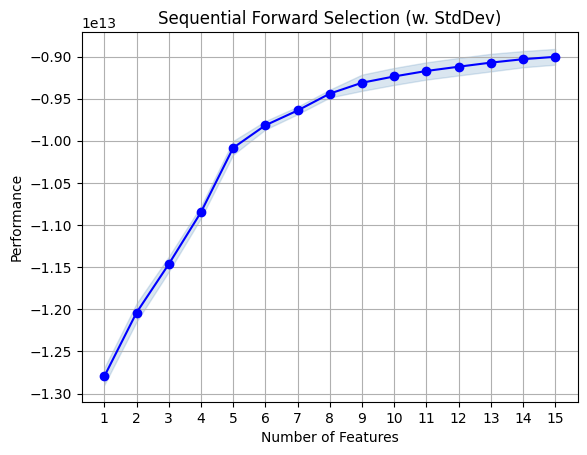

<Figure size 640x480 with 0 Axes>

In [36]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import os

fig = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

plt.savefig(os.path.join(ASSETS_DIR, 'sfs'))

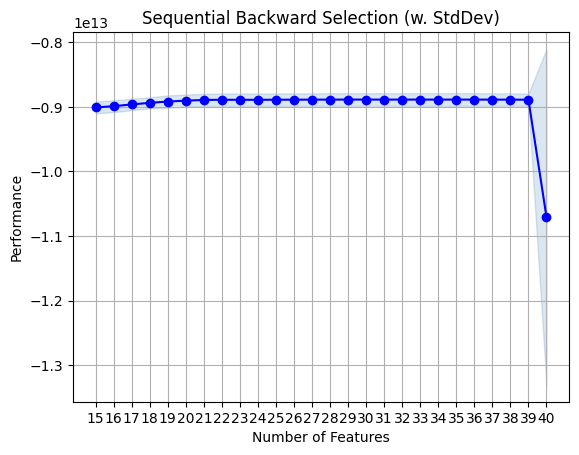

<Figure size 640x480 with 0 Axes>

In [37]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig = plot_sfs(sbs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Backward Selection (w. StdDev)')
plt.grid()
plt.show()

plt.savefig(os.path.join(ASSETS_DIR, 'sbs'))

In [38]:
selected_features = list(set(selected_features_sfs) | set(selected_features_sbs))
selected_features

['building_type_int_1',
 'KBinsDiscretizer__latitude_0.0',
 'floors_total',
 'building_type_int_6',
 'PolynomialFeatures__total_area^2',
 'PolynomialFeatures__total_area',
 'KBinsDiscretizer__longitude_2.0',
 'KBinsDiscretizer__longitude_3.0',
 'building_type_int_2',
 'KBinsDiscretizer__longitude_1.0',
 'KBinsDiscretizer__latitude_4.0',
 'KBinsDiscretizer__longitude_0.0',
 'KBinsDiscretizer__latitude_2.0',
 'KBinsDiscretizer__longitude_4.0',
 'kitchen_area',
 'building_type_int_4',
 'KBinsDiscretizer__latitude_3.0',
 'ceiling_height',
 'latitude',
 'has_elevator_True']

In [ ]:
# 4.4 Обучение новой версии модели

In [39]:
model3 = CatBoostRegressor(loss_function='RMSE')

model3.fit(train_ready_df[selected_features], y_train)

Learning rate set to 0.082389
0:	learn: 4632123.7253475	total: 16.4ms	remaining: 16.4s
1:	learn: 4439434.4465670	total: 28ms	remaining: 14s
2:	learn: 4268588.4712645	total: 39.5ms	remaining: 13.1s
3:	learn: 4115630.7240200	total: 51.8ms	remaining: 12.9s
4:	learn: 3979215.0874357	total: 63.8ms	remaining: 12.7s
5:	learn: 3853885.6855454	total: 78.3ms	remaining: 13s
6:	learn: 3744741.9834847	total: 95.6ms	remaining: 13.6s
7:	learn: 3651098.9345893	total: 107ms	remaining: 13.3s
8:	learn: 3569841.5267190	total: 120ms	remaining: 13.3s
9:	learn: 3493306.0330604	total: 142ms	remaining: 14.1s
10:	learn: 3426060.8384329	total: 170ms	remaining: 15.3s
11:	learn: 3368468.1883792	total: 194ms	remaining: 16s
12:	learn: 3316152.3660905	total: 222ms	remaining: 16.8s
13:	learn: 3269016.7160942	total: 249ms	remaining: 17.5s
14:	learn: 3226082.1770493	total: 281ms	remaining: 18.4s
15:	learn: 3190480.3602577	total: 306ms	remaining: 18.8s
16:	learn: 3157183.4174336	total: 332ms	remaining: 19.2s
17:	learn: 3

In [80]:
from sklearn.model_selection import StratifiedKFold, cross_validate

# крос валидация из 1го спринта
new_cv_res_1 = {}
cv_strategy = StratifiedKFold(n_splits=5)
cv_res = cross_validate(
        model3,
        train_ready_df[selected_features],
        y_train,
        cv=cv_strategy,
        n_jobs=-1,
        scoring=['neg_root_mean_squared_error', 'r2']
        )
for key, value in cv_res.items():
    new_cv_res_1[key] = round(value.mean(), 3)

print(new_cv_res_1)

/home/mle-user/mle_projects/mle-project-sprint-2/my_venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Learning rate set to 0.079535
Learning rate set to 0.079535
0:	learn: 4643339.7018524	total: 13.1ms	remaining: 13.1s
1:	learn: 4455758.4780730	total: 25ms	remaining: 12.5s
2:	learn: 4288277.4775411	total: 45.4ms	remaining: 15.1s
0:	learn: 4641794.0200994	total: 24.6ms	remaining: 24.6s
3:	learn: 4138111.0596605	total: 72.6ms	remaining: 18.1s
1:	learn: 4455143.6465056	total: 61.8ms	remaining: 30.8s
4:	learn: 4003707.3230047	total: 109ms	remaining: 21.7s
2:	learn: 4290635.7230613	total: 88.2ms	remaining: 29.3s
5:	learn: 3879470.4425220	total: 133ms	remaining: 22s
3:	learn: 4138572.3181559	total: 117ms	remaining: 29.1s
6:	learn: 3769970.2097482	total: 156ms	remaining: 22.1s
4:	learn: 4005329.8474222	total: 142ms	remaining: 28.2s
7:	learn: 3676179.8165201	total: 180ms	remaining: 22.4s
8:	learn: 3588584.5193648	total: 201ms	remaining: 22.1s
5:	learn: 3881347.9177734	total: 173ms	remaining: 28.6s
9:	learn: 3514581.0413404	total: 227ms	remaining: 22.4s
6:	learn: 3773147.8180974	total: 194ms	re

In [ ]:
# 4.5 Логирование всех артефактов в MLflow

In [81]:
import mlflow


RUN_NAME = 'Feature_selection_0'

experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)

if not experiment:
    experiment = mlflow.create_experiment(EXPERIMENT_NAME)

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id

    mlflow.sklearn.log_model(sfs, "Sequential Forward Selector")
    mlflow.sklearn.log_model(sbs, "Sequential Backward Selection")
    mlflow.log_artifacts(ASSETS_DIR) 

2024/08/25 18:47:05 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


2024/08/25 18:47:08 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


In [84]:
import mlflow

RUN_NAME = "model_3_registry_0"
REGISTRY_MODEL_NAME = "model_with_generated_and_selected_features"

pip_requirements = "../requirements.txt"
signature = mlflow.models.infer_signature(train_ready_df[selected_features], y_train)
input_example = train_ready_df[selected_features][:10]

experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)

if not experiment:
    experiment = mlflow.create_experiment(EXPERIMENT_NAME)

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    model_info = mlflow.catboost.log_model( 
            await_registration_for=60,
			cb_model=model3,
            artifact_path="models",
            registered_model_name=REGISTRY_MODEL_NAME,
            signature=signature,
            input_example=input_example,
            pip_requirements=pip_requirements
		)

Registered model 'model_with_generated_and_selected_features' already exists. Creating a new version of this model...
2024/08/25 18:47:40 INFO mlflow.tracking._model_registry.client: Waiting up to 60 seconds for model version to finish creation. Model name: model_with_generated_and_selected_features, version 4
Created version '4' of model 'model_with_generated_and_selected_features'.


In [85]:
with mlflow.start_run(run_id=run_id, experiment_id=experiment_id) as run:
    mlflow.log_metrics(new_cv_res_1)

### Этап 5 - подбор гиперпараметров и обучение новой версии модели
После того как мы уделили значительное внимание качеству модели через создание и отбор признаков, пришло время для финального штриха — подбора гиперпараметров. Этот этап является ключевым в финальной части проекта второго спринта, где ваша задача — оптимизировать гиперпараметры модели для достижения наилучшего качества.

Рекомендуется подобрать гиперпараметры как минимум двумя различными методами (например, с использованием Grid Search и Random Search), чтобы вы могли сравнить результаты и выбрать наиболее эффективный набор гиперпараметров для вашей модели. После определения оптимальных гиперпараметров, наступает время обучить финальную версию модели, используя ваши новые признаки.

Рекомендуемые шаги:

- Выбор методов для подбора гиперпараметров: Определитесь с методами, которые вы будете использовать для подбора гиперпараметров (например, Grid Search, Random Search, Bayesian Optimization).
- Подбор гиперпараметров: Примените выбранные методы для нахождения оптимальных значений гиперпараметров вашей модели.
- Сравнение результатов: Анализируйте и сравнивайте результаты, полученные различными методами, для определения наилучшего набора гиперпараметров.
- Обучение финальной модели: Используя выбранные гиперпараметры, обучите финальную версию вашей модели на новых признаках.
- Документирование процесса и результатов: Залогируйте все шаги и результаты в MLflow, включая сравнение методов подбора гиперпараметров и характеристики финальной модели.

Этот этап позволит вам максимально улучшить качество вашей модели перед финальной оценкой, предоставив полное понимание важности и влияния гиперпараметров на производительность модели.

In [ ]:
# 5.1 Подбор гиперпарметров при мощи метода номер 1

In [87]:
import optuna
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from optuna.integration.mlflow import MLflowCallback

RUN_NAME = "hyperparameters_selection_optuna_0"
MLFLOW_PARENT_RUN_ID = 'mlflow.parentRunId'

X_train_new = train_ready_df[selected_features]
X_test_new = test_ready_df[selected_features]

def objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True)
    depth = trial.suggest_int('depth', 6,10)
    iterations = trial.suggest_int('iterations', 30, 100)

    # создаём и обучаем модель
    model = CatBoostRegressor(learning_rate=learning_rate, depth=depth, iterations=iterations, bootstrap_type='No')
    model.fit(X_train_new, y_train)

    # предсказываем и вычисляем RMSE
    preds = model.predict(X_test_new)
    rmse = np.sqrt(mean_squared_error(y_test, preds))

    return rmse


experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if not experiment:
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
else:
    experiment_id = experiment.experiment_id
    

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id

mlflc = MLflowCallback(
    tracking_uri=f'http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}',
    metric_name="rmse",
    create_experiment=False,
    mlflow_kwargs={'experiment_id': experiment_id, 'tags': {MLFLOW_PARENT_RUN_ID: run_id}}
)

# создаём study и проводим оптимизацию
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10, callbacks=[mlflc])

# выводим результаты
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params) 

/tmp/ipykernel_3010/3176960784.py:41: ExperimentalWarning: MLflowCallback is experimental (supported from v1.4.0). The interface can change in the future.
  mlflc = MLflowCallback(
[I 2024-08-25 18:48:19,486] A new study created in memory with name: no-name-dc8a1165-dc24-4574-a606-ed399bb726ab


0:	learn: 4789658.7648584	total: 69.3ms	remaining: 3.26s
1:	learn: 4723570.9215286	total: 145ms	remaining: 3.34s
2:	learn: 4659496.5623844	total: 212ms	remaining: 3.18s
3:	learn: 4596736.2267736	total: 290ms	remaining: 3.19s
4:	learn: 4536701.9347189	total: 338ms	remaining: 2.91s
5:	learn: 4478328.4725455	total: 387ms	remaining: 2.71s
6:	learn: 4421301.2538820	total: 447ms	remaining: 2.62s
7:	learn: 4367256.6393013	total: 519ms	remaining: 2.59s
8:	learn: 4313768.3977166	total: 587ms	remaining: 2.54s
9:	learn: 4262661.6706159	total: 656ms	remaining: 2.49s
10:	learn: 4212908.3498630	total: 722ms	remaining: 2.43s
11:	learn: 4164417.8065998	total: 788ms	remaining: 2.36s
12:	learn: 4117309.4503365	total: 858ms	remaining: 2.31s
13:	learn: 4072387.5533219	total: 925ms	remaining: 2.25s
14:	learn: 4028327.4298664	total: 993ms	remaining: 2.19s
15:	learn: 3985156.0619611	total: 1.06s	remaining: 2.12s
16:	learn: 3944124.1601261	total: 1.14s	remaining: 2.08s
17:	learn: 3903819.8969781	total: 1.23s	

[I 2024-08-25 18:48:23,194] Trial 0 finished with value: 3181799.326083065 and parameters: {'learning_rate': 0.02325491762099814, 'depth': 10, 'iterations': 48}. Best is trial 0 with value: 3181799.326083065.


46:	learn: 3166533.5818155	total: 3.34s	remaining: 71.2ms
47:	learn: 3152345.5555265	total: 3.41s	remaining: 0us
0:	learn: 4818047.7081677	total: 22.8ms	remaining: 1.48s
1:	learn: 4780620.2834855	total: 48.1ms	remaining: 1.54s
2:	learn: 4742554.2943991	total: 69.9ms	remaining: 1.47s
3:	learn: 4705267.7789071	total: 93.9ms	remaining: 1.46s
4:	learn: 4668978.0899349	total: 117ms	remaining: 1.43s
5:	learn: 4634408.2617359	total: 142ms	remaining: 1.42s
6:	learn: 4599268.9673657	total: 188ms	remaining: 1.58s
7:	learn: 4565048.7007976	total: 216ms	remaining: 1.57s
8:	learn: 4531793.7780857	total: 242ms	remaining: 1.53s
9:	learn: 4498922.6938982	total: 267ms	remaining: 1.5s
10:	learn: 4467246.0086374	total: 287ms	remaining: 1.43s
11:	learn: 4435869.4940759	total: 316ms	remaining: 1.42s
12:	learn: 4404950.3388149	total: 334ms	remaining: 1.36s
13:	learn: 4374132.0771664	total: 359ms	remaining: 1.33s
14:	learn: 4344329.0459828	total: 381ms	remaining: 1.29s
15:	learn: 4315116.7573022	total: 413ms

[I 2024-08-25 18:48:25,079] Trial 1 finished with value: 3450057.956637573 and parameters: {'learning_rate': 0.014257242468405703, 'depth': 6, 'iterations': 66}. Best is trial 0 with value: 3181799.326083065.


61:	learn: 3465220.5129047	total: 1.44s	remaining: 93.1ms
62:	learn: 3454516.4911266	total: 1.47s	remaining: 69.8ms
63:	learn: 3443208.3576217	total: 1.49s	remaining: 46.4ms
64:	learn: 3432498.0012257	total: 1.5s	remaining: 23.1ms
65:	learn: 3422854.9375978	total: 1.53s	remaining: 0us
0:	learn: 4830160.1250525	total: 36.2ms	remaining: 1.41s
1:	learn: 4803995.8300086	total: 73.4ms	remaining: 1.39s
2:	learn: 4777222.1989464	total: 102ms	remaining: 1.26s
3:	learn: 4750828.5717760	total: 127ms	remaining: 1.14s
4:	learn: 4724985.1189679	total: 151ms	remaining: 1.06s
5:	learn: 4700214.1474348	total: 174ms	remaining: 985ms
6:	learn: 4674869.0512831	total: 191ms	remaining: 902ms
7:	learn: 4649836.9450690	total: 215ms	remaining: 861ms
8:	learn: 4625560.2595708	total: 238ms	remaining: 819ms
9:	learn: 4601389.9734138	total: 263ms	remaining: 790ms
10:	learn: 4577966.8601385	total: 286ms	remaining: 753ms
11:	learn: 4554574.6173540	total: 303ms	remaining: 707ms
12:	learn: 4531389.0629703	total: 322m

[I 2024-08-25 18:48:26,361] Trial 2 finished with value: 4055240.480643488 and parameters: {'learning_rate': 0.009896663845539111, 'depth': 6, 'iterations': 40}. Best is trial 0 with value: 3181799.326083065.


36:	learn: 4063905.3563672	total: 853ms	remaining: 69.1ms
37:	learn: 4047620.4532954	total: 876ms	remaining: 46.1ms
38:	learn: 4031500.8481137	total: 896ms	remaining: 23ms
39:	learn: 4015498.6285892	total: 916ms	remaining: 0us
0:	learn: 4857364.0029927	total: 26.4ms	remaining: 1.85s
1:	learn: 4857002.8258744	total: 53.9ms	remaining: 1.86s
2:	learn: 4856629.9882317	total: 72.2ms	remaining: 1.64s
3:	learn: 4856261.9993971	total: 88ms	remaining: 1.47s
4:	learn: 4855897.2884459	total: 107ms	remaining: 1.41s
5:	learn: 4855530.7211855	total: 148ms	remaining: 1.6s
6:	learn: 4855158.7200346	total: 180ms	remaining: 1.65s
7:	learn: 4854787.3866143	total: 220ms	remaining: 1.73s
8:	learn: 4854424.2462381	total: 246ms	remaining: 1.7s
9:	learn: 4854055.6420861	total: 281ms	remaining: 1.72s
10:	learn: 4853690.2962330	total: 304ms	remaining: 1.66s
11:	learn: 4853320.0785434	total: 323ms	remaining: 1.59s
12:	learn: 4852946.2289130	total: 349ms	remaining: 1.56s
13:	learn: 4852579.7250637	total: 386ms	re

[I 2024-08-25 18:48:29,265] Trial 3 finished with value: 4884965.492320608 and parameters: {'learning_rate': 0.00013032880097229782, 'depth': 7, 'iterations': 71}. Best is trial 0 with value: 3181799.326083065.


70:	learn: 4831725.6908136	total: 2.43s	remaining: 0us
0:	learn: 4856776.7601279	total: 20.6ms	remaining: 1.07s
1:	learn: 4855806.4208289	total: 56.8ms	remaining: 1.45s
2:	learn: 4854832.0230778	total: 76.8ms	remaining: 1.28s
3:	learn: 4853873.5240880	total: 96.6ms	remaining: 1.18s
4:	learn: 4852922.0831900	total: 116ms	remaining: 1.11s
5:	learn: 4851956.5413870	total: 136ms	remaining: 1.06s
6:	learn: 4850988.3362767	total: 156ms	remaining: 1.02s
7:	learn: 4850021.1409783	total: 175ms	remaining: 983ms
8:	learn: 4849071.1833524	total: 193ms	remaining: 945ms
9:	learn: 4848113.6287890	total: 214ms	remaining: 922ms
10:	learn: 4847150.8254615	total: 236ms	remaining: 900ms
11:	learn: 4846194.0494439	total: 255ms	remaining: 870ms
12:	learn: 4845237.6763461	total: 273ms	remaining: 840ms
13:	learn: 4844273.1024306	total: 292ms	remaining: 813ms
14:	learn: 4843333.9871475	total: 313ms	remaining: 792ms
15:	learn: 4842381.6771050	total: 332ms	remaining: 768ms
16:	learn: 4841419.7412835	total: 351ms

[I 2024-08-25 18:48:30,672] Trial 4 finished with value: 4860232.449190557 and parameters: {'learning_rate': 0.00032976823725800223, 'depth': 9, 'iterations': 53}. Best is trial 0 with value: 3181799.326083065.


51:	learn: 4808206.7545215	total: 1.07s	remaining: 20.6ms
52:	learn: 4807262.3572040	total: 1.09s	remaining: 0us
0:	learn: 4827025.2415490	total: 10.8ms	remaining: 1.04s
1:	learn: 4797932.3733156	total: 21ms	remaining: 995ms
2:	learn: 4768208.7564538	total: 31.3ms	remaining: 982ms
3:	learn: 4738955.2000978	total: 41.5ms	remaining: 966ms
4:	learn: 4710355.8478855	total: 54ms	remaining: 993ms
5:	learn: 4682986.7725082	total: 64.8ms	remaining: 982ms
6:	learn: 4655030.5124963	total: 75ms	remaining: 964ms
7:	learn: 4627464.9576320	total: 85.3ms	remaining: 949ms
8:	learn: 4600772.5462497	total: 95.9ms	remaining: 938ms
9:	learn: 4574244.8335868	total: 106ms	remaining: 925ms
10:	learn: 4548575.2959705	total: 117ms	remaining: 911ms
11:	learn: 4522985.7436488	total: 136ms	remaining: 964ms
12:	learn: 4497668.9136244	total: 151ms	remaining: 973ms
13:	learn: 4472348.8468138	total: 161ms	remaining: 956ms
14:	learn: 4447696.0014717	total: 172ms	remaining: 940ms
15:	learn: 4423447.3170879	total: 182ms

[I 2024-08-25 18:48:32,176] Trial 5 finished with value: 3364436.323447041 and parameters: {'learning_rate': 0.011024457525308451, 'depth': 6, 'iterations': 97}. Best is trial 0 with value: 3181799.326083065.


96:	learn: 3339602.7166193	total: 1.23s	remaining: 0us
0:	learn: 4848141.4239104	total: 35.1ms	remaining: 1.79s
1:	learn: 4838617.9666482	total: 66.9ms	remaining: 1.67s
2:	learn: 4829096.5120874	total: 100ms	remaining: 1.63s
3:	learn: 4819513.8476820	total: 135ms	remaining: 1.62s
4:	learn: 4810082.9551220	total: 168ms	remaining: 1.57s
5:	learn: 4800689.0925768	total: 200ms	remaining: 1.54s
6:	learn: 4791202.3815035	total: 242ms	remaining: 1.55s
7:	learn: 4781978.0908208	total: 275ms	remaining: 1.51s
8:	learn: 4772673.9689075	total: 308ms	remaining: 1.47s
9:	learn: 4763474.0806549	total: 343ms	remaining: 1.44s
10:	learn: 4754256.2393173	total: 377ms	remaining: 1.4s
11:	learn: 4745048.7542259	total: 410ms	remaining: 1.36s
12:	learn: 4735877.2743227	total: 447ms	remaining: 1.34s
13:	learn: 4726714.1521929	total: 483ms	remaining: 1.31s
14:	learn: 4717672.7030901	total: 517ms	remaining: 1.27s
15:	learn: 4708502.7225765	total: 551ms	remaining: 1.24s
16:	learn: 4699465.6664436	total: 584ms	re

[I 2024-08-25 18:48:34,219] Trial 6 finished with value: 4455828.02551172 and parameters: {'learning_rate': 0.0032643227640155753, 'depth': 10, 'iterations': 52}. Best is trial 0 with value: 3181799.326083065.


47:	learn: 4438466.1173648	total: 1.7s	remaining: 142ms
48:	learn: 4430512.8916537	total: 1.74s	remaining: 107ms
49:	learn: 4422798.3054252	total: 1.78s	remaining: 71.1ms
50:	learn: 4415011.6596386	total: 1.81s	remaining: 35.5ms
51:	learn: 4407243.3193699	total: 1.84s	remaining: 0us
0:	learn: 4854866.9865875	total: 10.4ms	remaining: 782ms
1:	learn: 4852112.0870160	total: 20.5ms	remaining: 759ms
2:	learn: 4849258.3400631	total: 30.4ms	remaining: 741ms
3:	learn: 4846408.9929109	total: 40.8ms	remaining: 734ms
4:	learn: 4843585.3597139	total: 51.1ms	remaining: 726ms
5:	learn: 4840748.8946181	total: 61.3ms	remaining: 715ms
6:	learn: 4837909.4667506	total: 72.3ms	remaining: 713ms
7:	learn: 4835071.3343246	total: 82.2ms	remaining: 699ms
8:	learn: 4832284.2688177	total: 92.5ms	remaining: 689ms
9:	learn: 4829471.4197506	total: 103ms	remaining: 679ms
10:	learn: 4826656.7407616	total: 113ms	remaining: 665ms
11:	learn: 4823848.1871816	total: 123ms	remaining: 654ms
12:	learn: 4821043.6433062	total:

[I 2024-08-25 18:48:35,273] Trial 7 finished with value: 4703959.490279511 and parameters: {'learning_rate': 0.0010273406266452184, 'depth': 6, 'iterations': 76}. Best is trial 0 with value: 3181799.326083065.


0:	learn: 4857064.4604313	total: 19.7ms	remaining: 788ms
1:	learn: 4856385.4104607	total: 39.2ms	remaining: 765ms
2:	learn: 4855703.4328822	total: 58.2ms	remaining: 737ms
3:	learn: 4855032.4970621	total: 78ms	remaining: 721ms
4:	learn: 4854366.4099490	total: 97.1ms	remaining: 699ms
5:	learn: 4853690.3706747	total: 117ms	remaining: 684ms
6:	learn: 4853012.3799512	total: 142ms	remaining: 687ms
7:	learn: 4852335.0014156	total: 163ms	remaining: 673ms
8:	learn: 4851669.6085684	total: 195ms	remaining: 693ms
9:	learn: 4850998.8139087	total: 215ms	remaining: 665ms
10:	learn: 4850324.2617530	total: 235ms	remaining: 641ms
11:	learn: 4849653.8277854	total: 254ms	remaining: 614ms
12:	learn: 4848983.5863334	total: 273ms	remaining: 589ms
13:	learn: 4848307.5197878	total: 292ms	remaining: 563ms
14:	learn: 4847649.2049445	total: 314ms	remaining: 545ms
15:	learn: 4846981.5563164	total: 338ms	remaining: 528ms
16:	learn: 4846307.0709881	total: 357ms	remaining: 504ms
17:	learn: 4845630.8129661	total: 376m

[I 2024-08-25 18:48:36,367] Trial 8 finished with value: 4883532.820532146 and parameters: {'learning_rate': 0.0002307399426191997, 'depth': 9, 'iterations': 41}. Best is trial 0 with value: 3181799.326083065.


32:	learn: 4835631.8633435	total: 668ms	remaining: 162ms
33:	learn: 4834972.0289415	total: 687ms	remaining: 141ms
34:	learn: 4834305.0405222	total: 706ms	remaining: 121ms
35:	learn: 4833640.0228655	total: 726ms	remaining: 101ms
36:	learn: 4832973.8725809	total: 747ms	remaining: 80.7ms
37:	learn: 4832301.3333653	total: 767ms	remaining: 60.5ms
38:	learn: 4831633.6225077	total: 786ms	remaining: 40.3ms
39:	learn: 4830966.2205617	total: 808ms	remaining: 20.2ms
40:	learn: 4830294.1147485	total: 827ms	remaining: 0us
0:	learn: 4856607.5146840	total: 10.4ms	remaining: 438ms
1:	learn: 4855523.6492648	total: 22ms	remaining: 451ms
2:	learn: 4854399.9387423	total: 32.5ms	remaining: 433ms
3:	learn: 4853276.9685844	total: 43.8ms	remaining: 427ms
4:	learn: 4852163.2084453	total: 54.3ms	remaining: 412ms
5:	learn: 4851043.3876766	total: 64.7ms	remaining: 399ms
6:	learn: 4849921.3999877	total: 75.1ms	remaining: 386ms
7:	learn: 4848798.9501590	total: 85.5ms	remaining: 374ms
8:	learn: 4847695.8218728	total

[I 2024-08-25 18:48:37,037] Trial 9 finished with value: 4863063.426762756 and parameters: {'learning_rate': 0.00040378802030037356, 'depth': 6, 'iterations': 43}. Best is trial 0 with value: 3181799.326083065.


37:	learn: 4815643.9482566	total: 420ms	remaining: 55.2ms
38:	learn: 4814550.4731517	total: 430ms	remaining: 44.1ms
39:	learn: 4813455.1489220	total: 440ms	remaining: 33ms
40:	learn: 4812355.8913621	total: 451ms	remaining: 22ms
41:	learn: 4811255.5062383	total: 462ms	remaining: 11ms
42:	learn: 4810159.9832197	total: 472ms	remaining: 0us
Number of finished trials: 10
Best trial: {'learning_rate': 0.02325491762099814, 'depth': 10, 'iterations': 48}


In [89]:
study.best_value

3181799.326083065

In [ ]:
# 5.2 Подбор гиперпарметров при мощи метода номер 2

In [103]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV

X_train_new = train_ready_df[selected_features]

model = CatBoostRegressor(bootstrap_type='No')

param_grid = {
    'depth' : [6,8,10],
    'learning_rate' : [1e-4, 1e-3, 1e-2, 1e-1],
    'iterations' : [30, 50, 100]
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', error_score='raise')

clf = grid_search.fit(X_train_new, y_train)


cv_results = pd.DataFrame(clf.cv_results_)

print("Лучшие гиперпараметры:", grid_search.best_params_)
print("Лучший счет:", grid_search.best_score_)

best_model = grid_search.best_estimator_

0:	learn: 4854104.8779131	total: 25.8ms	remaining: 747ms
1:	learn: 4853835.2946877	total: 65.4ms	remaining: 916ms
2:	learn: 4853572.6023273	total: 78.4ms	remaining: 706ms
3:	learn: 4853294.6487488	total: 88.3ms	remaining: 574ms
4:	learn: 4853018.4065690	total: 98ms	remaining: 490ms
5:	learn: 4852745.1737119	total: 107ms	remaining: 430ms
6:	learn: 4852468.0900060	total: 117ms	remaining: 384ms
7:	learn: 4852188.5968741	total: 128ms	remaining: 351ms
8:	learn: 4851915.4543458	total: 137ms	remaining: 320ms
9:	learn: 4851637.0925935	total: 147ms	remaining: 293ms
10:	learn: 4851364.7549710	total: 156ms	remaining: 269ms
11:	learn: 4851087.7802093	total: 166ms	remaining: 250ms
12:	learn: 4850813.4811327	total: 176ms	remaining: 230ms
13:	learn: 4850539.4127266	total: 187ms	remaining: 213ms
14:	learn: 4850268.1949139	total: 196ms	remaining: 196ms
15:	learn: 4849993.6276714	total: 206ms	remaining: 180ms
16:	learn: 4849715.9582069	total: 215ms	remaining: 165ms
17:	learn: 4849437.3864030	total: 228m

In [104]:
cv_results

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_depth   
0        0.457782      0.072442         0.007008        0.003238           6  \
1        0.790867      0.136130         0.014940        0.004264           6   
2        0.830629      0.199827         0.012722        0.004557           6   
3        0.414680      0.020173         0.006734        0.000309           6   
4        1.158393      0.414930         0.012031        0.005431           6   
5        0.605033      0.008558         0.005367        0.000383           6   
6        0.884401      0.237575         0.006238        0.000651           6   
7        0.876379      0.205584         0.007416        0.001525           6   
8        1.383040      0.275551         0.006611        0.000273           6   
9        1.832177      0.516282         0.008567        0.002318           6   
10       1.935467      0.527866         0.013177        0.005087           6   
11       1.308186      0.249295         0.011985        0.007461           6   
12       1.012088      0.478056         0.009932        0.004950           8   
13       0.895536      0.394576         0.006722        0.000786           8   
14       0.769771      0.309698         0.008917        0.002481           8   
15       0.776950      0.317958         0.007670        0.001883           8   
16       1.402856      0.498641         0.013888        0.005579           8   
17       1.324232      0.484009         0.011462        0.006600           8   
18       1.211604      0.220265         0.008716        0.003207           8   
19       0.949000      0.098217         0.008627        0.002851           8   
20       2.263034      0.880826         0.011704        0.004855           8   
21       2.918254      0.605192         0.013450        0.004464           8   
22       1.792726      0.149024         0.007875        0.000254           8   
23       2.348418      0.742048         0.012648        0.005558           8   
24       1.707827      0.377596         0.015369        0.006614          10   
25       1.763299      0.544965         0.015482        0.006640          10   
26       1.199071      0.010026         0.010529        0.004087          10   
27       1.973915      0.447614         0.017139        0.004962          10   
28       2.814221      0.461846         0.012802        0.004166          10   
29       2.216971      0.270760         0.015347        0.008815          10   
30       3.103567      0.650823         0.019616        0.005624          10   
31       2.416105      0.612105         0.014370        0.004837          10   
32       5.089294      0.891454         0.021093        0.005614          10   
33       5.154692      0.575327         0.020170        0.007557          10   
34       4.858350      0.677893         0.015442        0.006502          10   
35       4.730172      0.793701         0.030764        0.020590          10   

   param_iterations param_learning_rate   
0                30              0.0001  \
1                30               0.001   
2                30                0.01   
3                30                 0.1   
4                50              0.0001   
5                50               0.001   
6                50                0.01   
7                50                 0.1   
8               100              0.0001   
9               100               0.001   
10              100                0.01   
11              100                 0.1   
12               30              0.0001   
13               30               0.001   
14               30                0.01   
15               30                 0.1   
16               50              0.0001   
17               50               0.001   
18               50                0.01   
19               50                 0.1   
20              100              0.0001   
21              100               0.001   
22              100                0.01   
23         

In [ ]:
# 5.3 Формирование списка гиперпараметров для новой модели

In [105]:
fig = optuna.visualization.plot_param_importances(study)
fig.show() 

In [88]:

# Выбираем результаты полученные Optuna, так как у нее лучший результат mean_squared_error

parameters = study.best_trial.params
parameters

{'learning_rate': 0.02325491762099814, 'depth': 10, 'iterations': 48}

In [ ]:
# 5.4 Обучение финальной версии модели

In [91]:
model4 = CatBoostRegressor(loss_function='RMSE', **parameters)

model4.fit(train_ready_df[selected_features], y_train)

0:	learn: 4790206.7689618	total: 83.7ms	remaining: 3.93s
1:	learn: 4723579.2877260	total: 140ms	remaining: 3.22s
2:	learn: 4660108.6454699	total: 172ms	remaining: 2.58s
3:	learn: 4598563.4888601	total: 208ms	remaining: 2.29s
4:	learn: 4537531.7601160	total: 241ms	remaining: 2.07s
5:	learn: 4478472.1578283	total: 274ms	remaining: 1.92s
6:	learn: 4422446.7029213	total: 309ms	remaining: 1.81s
7:	learn: 4366725.3026675	total: 341ms	remaining: 1.7s
8:	learn: 4313285.2925163	total: 374ms	remaining: 1.62s
9:	learn: 4261338.2573395	total: 406ms	remaining: 1.54s
10:	learn: 4211148.4452298	total: 441ms	remaining: 1.48s
11:	learn: 4162606.7939654	total: 475ms	remaining: 1.42s
12:	learn: 4115996.8534904	total: 519ms	remaining: 1.4s
13:	learn: 4070237.9334987	total: 555ms	remaining: 1.35s
14:	learn: 4025897.4148066	total: 593ms	remaining: 1.3s
15:	learn: 3983552.6229719	total: 627ms	remaining: 1.25s
16:	learn: 3942041.2673732	total: 659ms	remaining: 1.2s
17:	learn: 3901672.1681563	total: 691ms	rema

In [92]:
from sklearn.model_selection import StratifiedKFold, cross_validate

new_cv_res_2 = {}
cv_strategy = StratifiedKFold(n_splits=5)
cv_res = cross_validate(
        model4,
        train_ready_df[selected_features],
        y_train,
        cv=cv_strategy,
        n_jobs=-1,
        scoring=['neg_root_mean_squared_error', 'r2']
        )
for key, value in cv_res.items():
    new_cv_res_2[key] = round(value.mean(), 3)

print(new_cv_res_2)

/home/mle-user/mle_projects/mle-project-sprint-2/my_venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


0:	learn: 4791808.6116049	total: 96.2ms	remaining: 4.52s
0:	learn: 4795409.0386535	total: 145ms	remaining: 6.82s
1:	learn: 4725836.1431644	total: 162ms	remaining: 3.73s
1:	learn: 4729623.4914442	total: 212ms	remaining: 4.88s
2:	learn: 4661880.7983057	total: 234ms	remaining: 3.51s
3:	learn: 4599841.2125247	total: 309ms	remaining: 3.4s
2:	learn: 4665275.2584896	total: 299ms	remaining: 4.48s
3:	learn: 4603647.2535549	total: 367ms	remaining: 4.04s
4:	learn: 4539727.1776179	total: 386ms	remaining: 3.32s
5:	learn: 4481043.7263834	total: 452ms	remaining: 3.16s
4:	learn: 4542424.0916261	total: 459ms	remaining: 3.95s
6:	learn: 4424989.6256114	total: 514ms	remaining: 3.01s
5:	learn: 4482773.9191129	total: 529ms	remaining: 3.71s
7:	learn: 4370286.9289920	total: 581ms	remaining: 2.9s
6:	learn: 4426507.5476496	total: 594ms	remaining: 3.48s
8:	learn: 4317289.6081632	total: 646ms	remaining: 2.8s
7:	learn: 4370780.9410989	total: 658ms	remaining: 3.29s
9:	learn: 4266105.5097348	total: 730ms	remaining: 

In [93]:
# Посчитаем r2 метрику итоговой модели на тестовых данных

metric = model4.score(test_ready_df[selected_features], y_test)
metric

0.5785755662605767

In [94]:
new_cv_res_2['test_r2'] = metric

In [ ]:
# 5.5 Логирование артефактов в MLflow

In [95]:
import mlflow

RUN_NAME = "model_4_registry_0"
REGISTRY_MODEL_NAME = "model_with_best_hyperparameters_0"

pip_requirements = "../requirements.txt"
signature = mlflow.models.infer_signature(train_ready_df[selected_features], y_train)
input_example = train_ready_df[selected_features][:10]

experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)

if not experiment:
    experiment = mlflow.create_experiment(EXPERIMENT_NAME)

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    model_info = mlflow.catboost.log_model( 
            await_registration_for=60,
			cb_model=model4,
            artifact_path="models",
            registered_model_name=REGISTRY_MODEL_NAME,
            signature=signature,
            input_example=input_example,
            pip_requirements=pip_requirements
		)

Successfully registered model 'model_with_best_hyperparameters_0'.
2024/08/25 19:06:33 INFO mlflow.tracking._model_registry.client: Waiting up to 60 seconds for model version to finish creation. Model name: model_with_best_hyperparameters_0, version 1
Created version '1' of model 'model_with_best_hyperparameters_0'.


In [96]:
with mlflow.start_run(run_id=run_id, experiment_id=experiment_id) as run:
    mlflow.log_metrics(new_cv_res_2)